# Title: Premier League Predictions
### Author:  Lukas Kaestner

#### Background: 

One of my true passions is soccer. I have been playing/watching soccer all of my life and especially following the English Premier League. In the midst of the current coronavirus affected market, I wanted to continue my data science education and apply my skills to a project on my own. On top of what I have learned throughout my MS program, I have taken numerous DataCamp courses and applied what I learned in this project as well.

#### Goal:

The goal is to be able to predict the outcomes of English Premier League soccer games. After finding the best model possible, I plan to test it out on games from the 2019/2020 season using the odds produced by oddsmakers to see the financial impact of using the model.


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## Table of Contents
1. Importing Data
2. Preprocessing Data
3. Merging Data
4. Feature Engineering
5. Data Types
6. Explore Data
7. Modeling - Method 1 (3 Class Classification)

    7a. KNN \
    7b. Decision Tree \
    7c. Random Forest \
    7d. Random Forest with Grid Search \
    7e. Final Random Forest Model
    
    
8. Modeling - Method 2 (Predicting Goals Scored of Each Team)
    
     8a. Re-feed Goal Prediction into another Random Forest Model \
     8b. Re-feed Goal Prediction into another Neural Network
     
     
9. Using Models for 2019/20 Matches

## 1. Importing Data

In [2]:
# Import standings data
standings = pd.read_csv('result.csv')

# Import match result data
matches = pd.read_csv('EPL 2000-2018 (1).csv')

In [3]:
# View top of matches
matches.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,AST,HF,AF,HC,AC,HY,AY,HR,AR,Season
0,19/08/00,Charlton,Man City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,4.0,13.0,12.0,6.0,6.0,1.0,2.0,0.0,0.0,00-01
1,19/08/00,Chelsea,West Ham,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,5.0,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,00-01
2,19/08/00,Coventry,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,9.0,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,00-01
3,19/08/00,Derby,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,6.0,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,00-01
4,19/08/00,Leeds,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,6.0,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,00-01


In [4]:
# View top of standings
standings.head()

,year,title,Team,A,D,F,GD,L,P,Pos,Pts,W
0,2016/2017,Premier League 2016-2017,Chelsea,33,3,85,52,5,38,1,93,30
1,2016/2017,Premier League 2016-2017,Tottenham Hotspurs,26,8,86,60,4,38,2,86,26
2,2016/2017,Premier League 2016-2017,Manchester City,39,9,80,41,6,38,3,78,23
3,2016/2017,Premier League 2016-2017,Liverpool,42,10,78,36,6,38,4,76,22
4,2016/2017,Premier League 2016-2017,Arsenal,44,6,77,33,9,38,5,75,23


## 2. Preprocessing

### Consistent naming and key for joining

In [5]:
# Add column to matches to indicate last year's season for joining with standings

matches['Last_Season'] = '1999/2000'
matches['Last_Season'].loc[matches.Season == '00-01'] = '1999/2000'
matches['Last_Season'].loc[matches.Season == '01-02'] = '2000/2001'
matches['Last_Season'].loc[matches.Season == '02-03'] = '2001/2002'
matches['Last_Season'].loc[matches.Season == '03-04'] = '2002/2003'
matches['Last_Season'].loc[matches.Season == '04-05'] = '2003/2004'
matches['Last_Season'].loc[matches.Season == '05-06'] = '2004/2005'
matches['Last_Season'].loc[matches.Season == '06-07'] = '2005/2006'
matches['Last_Season'].loc[matches.Season == '07-08'] = '2006/2007'
matches['Last_Season'].loc[matches.Season == '08-09'] = '2007/2008'
matches['Last_Season'].loc[matches.Season == '09-10'] = '2008/2009'
matches['Last_Season'].loc[matches.Season == '10-11'] = '2009/2010'
matches['Last_Season'].loc[matches.Season == '11-12'] = '2010/2011'
matches['Last_Season'].loc[matches.Season == '12-13'] = '2011/2012'
matches['Last_Season'].loc[matches.Season == '13-14'] = '2012/2013'
matches['Last_Season'].loc[matches.Season == '14-15'] = '2013/2014'
matches['Last_Season'].loc[matches.Season == '15-16'] = '2014/2015'
matches['Last_Season'].loc[matches.Season == '16-17'] = '2015/2016'
matches['Last_Season'].loc[matches.Season == '17-18'] = '2016/2017'

/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
# Consistent team naming across both datasets

matches.HomeTeam.loc[matches.HomeTeam == "Birmingham"] = "Birmingham City"
matches.AwayTeam.loc[matches.AwayTeam == "Birmingham"] = "Birmingham City"
matches.HomeTeam.loc[matches.HomeTeam == "Man City"] = "Manchester City"
matches.AwayTeam.loc[matches.AwayTeam == "Man City"] = "Manchester City"
matches.HomeTeam.loc[matches.HomeTeam == "Man United"] = "Manchester United"
matches.AwayTeam.loc[matches.AwayTeam == "Man United"] = "Manchester United"
matches.HomeTeam.loc[matches.HomeTeam == "Swansea"] = "Swansea City"
matches.AwayTeam.loc[matches.AwayTeam == "Swansea"] = "Swansea City"
matches.HomeTeam.loc[matches.HomeTeam == "Charlton"] = "Charlton Athletic"
matches.AwayTeam.loc[matches.AwayTeam == "Charlton"] = "Charlton Athletic"
matches.HomeTeam.loc[matches.HomeTeam == "Coventry"] = "Coventry City"
matches.AwayTeam.loc[matches.AwayTeam == "Coventry"] = "Coventry City"
matches.HomeTeam.loc[matches.HomeTeam == "Derby"] = "Derby County"
matches.AwayTeam.loc[matches.AwayTeam == "Derby"] = "Derby County"
matches.HomeTeam.loc[matches.HomeTeam == "Leicester"] = "Leicester City"
matches.AwayTeam.loc[matches.AwayTeam == "Leicester"] = "Leicester City"
matches.HomeTeam.loc[matches.HomeTeam == "Bradford"] = "Bradford City"
matches.AwayTeam.loc[matches.AwayTeam == "Bradford"] = "Bradford City"
matches.HomeTeam.loc[matches.HomeTeam == "Ipswich"] = "Ipswich Town"
matches.AwayTeam.loc[matches.AwayTeam == "Ipswich"] = "Ipswich Town"
matches.HomeTeam.loc[matches.HomeTeam == "West Ham"] = "West Ham United"
matches.AwayTeam.loc[matches.AwayTeam == "West Ham"] = "West Ham United"
matches.HomeTeam.loc[matches.HomeTeam == "Tottenham"] = "Tottenham Hotspurs"
matches.AwayTeam.loc[matches.AwayTeam == "Tottenham"] = "Tottenham Hotspurs"
matches.HomeTeam.loc[matches.HomeTeam == "Leeds"] = "Leeds United"
matches.AwayTeam.loc[matches.AwayTeam == "Leeds"] = "Leeds United"
matches.HomeTeam.loc[matches.HomeTeam == "West Brom"] = "West Bromwich Albion"
matches.AwayTeam.loc[matches.AwayTeam == "West Brom"] = "West Bromwich Albion"
matches.HomeTeam.loc[matches.HomeTeam == "Bolton"] = "Bolton Wanderers"
matches.AwayTeam.loc[matches.AwayTeam == "Bolton"] = "Bolton Wanderers"
matches.HomeTeam.loc[matches.HomeTeam == "Blackburn"] = "Blackburn Rovers"
matches.AwayTeam.loc[matches.AwayTeam == "Blackburn"] = "Blackburn Rovers"
matches.HomeTeam.loc[matches.HomeTeam == "Newcastle"] = "Newcastle United"
matches.AwayTeam.loc[matches.AwayTeam == "Newcastle"] = "Newcastle United"
matches.HomeTeam.loc[matches.HomeTeam == "Cardiff"] = "Cardiff City"
matches.AwayTeam.loc[matches.AwayTeam == "Cardiff"] = "Cardiff City"
matches.HomeTeam.loc[matches.HomeTeam == "Huddersfield"] = "Huddersfield Town"
matches.AwayTeam.loc[matches.AwayTeam == "Huddersfield"] = "Huddersfield Town"
matches.HomeTeam.loc[matches.HomeTeam == "Hull"] = "Hull City"
matches.AwayTeam.loc[matches.AwayTeam == "Hull"] = "Hull City"
matches.HomeTeam.loc[matches.HomeTeam == "Middlesboro"] = "Middlesbrough"
matches.AwayTeam.loc[matches.AwayTeam == "Middlesboro"] = "Middlesbrough"
matches.HomeTeam.loc[matches.HomeTeam == "Norwich"] = "Norwich City"
matches.AwayTeam.loc[matches.AwayTeam == "Norwich"] = "Norwich City"
matches.HomeTeam.loc[matches.HomeTeam == "QPR"] = "Queens Park Rangers"
matches.AwayTeam.loc[matches.AwayTeam == "QPR"] = "Queens Park Rangers"
matches.HomeTeam.loc[matches.HomeTeam == "Stoke"] = "Stoke City"
matches.AwayTeam.loc[matches.AwayTeam == "Stoke"] = "Stoke City"
matches.HomeTeam.loc[matches.HomeTeam == "Wolves"] = "Wolverhampton Wanderers"
matches.AwayTeam.loc[matches.AwayTeam == "Wolves"] = "Wolverhampton Wanderers"

In [7]:
# Consistent year naming

standings.year.loc[standings.year == "2002/3"] = "2002/2003"
standings.year.loc[standings.year == "2003/4"] = "2003/2004"
standings.year.loc[standings.year == "2004/5"] = "2004/2005"
standings.year.loc[standings.year == "2005/6"] = "2005/2006"

### Insert Missing Season Results

In [8]:
# Extract necessary rows of standings
simple_standings = standings[["year", "Team", "Pts", "F", "A"]]


# Create each row for the 2015/2016 standings
new_row1 = {'year':'2015/2016', 'Team': 'Leicester City', 'Pts': 81, 'F': '68', 'A': '36'}
new_row2 = {'year':'2015/2016', 'Team': 'Arsenal', 'Pts': 71, 'F': '65', 'A': '36'}
new_row3 = {'year':'2015/2016', 'Team': 'Tottenham Hotspurs', 'Pts': 70, 'F': '69', 'A': '35'}
new_row4 = {'year':'2015/2016', 'Team': 'Manchester City', 'Pts': 66, 'F': '71', 'A': '41'}
new_row5 = {'year':'2015/2016', 'Team': 'Manchester United', 'Pts': 63, 'F': '46', 'A': '34'}
new_row6 = {'year':'2015/2016', 'Team': 'Southampton', 'Pts': 63, 'F': '59', 'A': '41'}
new_row7 = {'year':'2015/2016', 'Team': 'West Ham United', 'Pts': 62, 'F': '65', 'A': '51'}
new_row8 = {'year':'2015/2016', 'Team': 'Liverpool', 'Pts': 60, 'F': '63', 'A': '50'}
new_row9 = {'year':'2015/2016', 'Team': 'Stoke City', 'Pts': 51, 'F': '41', 'A': '55'}
new_row10 = {'year':'2015/2016', 'Team': 'Chelsea', 'Pts': 50, 'F': '59', 'A': '53'}
new_row11 = {'year':'2015/2016', 'Team': 'Everton', 'Pts': 47, 'F': '59', 'A': '55'}
new_row12 = {'year':'2015/2016', 'Team': 'Swansea City', 'Pts': 47, 'F': '42', 'A': '52'}
new_row13 = {'year':'2015/2016', 'Team': 'Watford', 'Pts': 45, 'F': '40', 'A': '50'}
new_row14 = {'year':'2015/2016', 'Team': 'West Bromwich Albion', 'Pts': 43, 'F': '34', 'A': '48'}
new_row15 = {'year':'2015/2016', 'Team': 'Crystal Palace', 'Pts': 42, 'F': '29', 'A': '51'}
new_row16 = {'year':'2015/2016', 'Team': 'Bournemouth', 'Pts': 42, 'F': '44', 'A': '64'}
new_row17 = {'year':'2015/2016', 'Team': 'Sunderland', 'Pts': 39, 'F': '48', 'A': '62'}
new_row18 = {'year':'2015/2016', 'Team': 'Newcastle United', 'Pts': 37, 'F': '44', 'A': '65'}
new_row19 = {'year':'2015/2016', 'Team': 'Norwich City', 'Pts': 34, 'F': '39', 'A': '67'}
new_row20 = {'year':'2015/2016', 'Team': 'Aston Villa', 'Pts': 17, 'F': '27', 'A': '76'}


# Add rows to simple_standings 
simple_standings = simple_standings.append([new_row1, new_row2, new_row3, new_row4, new_row5,
                                            new_row6, new_row7, new_row8, new_row9, new_row10,
                                            new_row11, new_row12, new_row13, new_row14, new_row15,
                                            new_row16, new_row17, new_row18, new_row19, new_row20], 
                                            ignore_index=True)

In [9]:
# Rename columns
simple_standings.columns = ['Year', 'Team', 'Last_Pts', 'Last_Goals_F', 'Last_Goals_A']

In [10]:
# Sort values by year and points
simple_standings.sort_values(['Year', 'Last_Pts'], ascending = False).reset_index(drop = True)

,Year,Team,Last_Pts,Last_Goals_F,Last_Goals_A
0,2016/2017,Chelsea,93,85,33
1,2016/2017,Tottenham Hotspurs,86,86,26
2,2016/2017,Manchester City,78,80,39
3,2016/2017,Liverpool,76,78,42
4,2016/2017,Arsenal,75,77,44
...,...,...,...,...,...
1358,1888/1889,Everton,20,35,46
1359,1888/1889,Burnley,17,42,62
1360,1888/1889,Derby County,16,41,60
1361,1888/1889,Notts County,12,39,73


## 3. Merging Datasets

In [11]:
# Merge matches for home team
matches = matches.merge(simple_standings, left_on = ["Last_Season", "HomeTeam"], 
                        right_on = ["Year", "Team"], how = 'left')

In [12]:
# Merge matches for away team
matches = matches.merge(simple_standings, left_on = ["Last_Season", "AwayTeam"], 
                        right_on = ["Year", "Team"], how = 'left')

In [13]:
# Rename Columns

matches = matches.rename(columns={'Last_Pts_x': 'Home_Last_Pts', 
                                  'Last_Goals_F_x': 'Home_Last_Goals_F', 
                                  'Last_Goals_A_x': 'Home_Last_Goals_A',
                                  'Last_Pts_y': 'Away_Last_Pts', 
                                  'Last_Goals_F_y': 'Away_Last_Goals_F', 
                                  'Last_Goals_A_y': 'Away_Last_Goals_A' })

In [14]:
# Delete merging columns in matches

del matches['Team_x']
del matches['Team_y']
del matches['Year_x']
del matches['Year_y']

In [15]:
# View matches dataset
matches

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,HR,AR,Season,Last_Season,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,Away_Last_Goals_A
0,19/08/00,Charlton Athletic,Manchester City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,0.0,0.0,00-01,1999/2000,NaN,NaN,NaN,NaN,NaN,NaN
1,19/08/00,Chelsea,West Ham United,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,0.0,0.0,00-01,1999/2000,65.0,53,34,55.0,52,53
2,19/08/00,Coventry City,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,1.0,0.0,00-01,1999/2000,44.0,47,54,52.0,46,52
3,19/08/00,Derby County,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,0.0,0.0,00-01,1999/2000,38.0,44,57,44.0,45,62
4,19/08/00,Leeds United,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,0.0,0.0,00-01,1999/2000,69.0,58,43,50.0,59,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6456,13/05/18,Newcastle United,Chelsea,3.0,0.0,H,1.0,0.0,H,M Atkinson,...,0.0,0.0,17-18,2016/2017,NaN,NaN,NaN,93.0,85,33
6457,13/05/18,Southampton,Manchester City,0.0,1.0,A,0.0,0.0,D,A Marriner,...,0.0,0.0,17-18,2016/2017,46.0,41,48,78.0,80,39
6458,13/05/18,Swansea City,Stoke City,1.0,2.0,A,1.0,2.0,A,A Taylor,...,0.0,0.0,17-18,2016/2017,41.0,45,70,44.0,41,56
6459,13/05/18,Tottenham Hotspurs,Leicester City,5.0,4.0,H,1.0,2.0,A,C Pawson,...,0.0,0.0,17-18,2016/2017,86.0,86,26,44.0,48,63


We can see missing values in last season points, goals for and goals away because that team was promoted from a lower division the year before. Therefore, we do not have any data on how they performed in the premier league the year before.

## 4. Feature Engineering

### Relegation Previous Year

In [16]:
# Add last year relegation column for home and away team


matches['Home_Previous_Relegation'] = ''
matches['Home_Previous_Relegation'].loc[matches.Home_Last_Pts.isna() == True] = 1
matches['Home_Previous_Relegation'].loc[matches.Home_Last_Pts.isna() == False] = 0

matches['Away_Previous_Relegation'] = ''
matches['Away_Previous_Relegation'].loc[matches.Away_Last_Pts.isna() == True] = 1
matches['Away_Previous_Relegation'].loc[matches.Away_Last_Pts.isna() == False] = 0


### Number of Days Between Games and Previous Games Win

Assumptions: 

1) Only considering league game schedule. Lots of teams play in other tournaments throughout their season but those matches are not captured in our dataset.

2) 15 days resst before the start of the first game each season. Teams play some preseason games before the actual season starts

In [17]:
# Convert 'Date' from object
matches.Date[0:380] = pd.to_datetime(matches.Date[0:380], format = '%d/%m/%y', errors = 'coerce')
matches.Date[380:760] = pd.to_datetime(matches.Date[380:760], format = '%d/%m/%Y')
matches.Date[760:] = pd.to_datetime(matches.Date[760:], format = '%d/%m/%y', errors = 'coerce')

# Sort values by 'Date'
matches.sort_values('Date')


/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,...,Season,Last_Season,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,Away_Last_Goals_A,Home_Previous_Relegation,Away_Previous_Relegation
0,2000-08-19 00:00:00,Charlton Athletic,Manchester City,4.0,0.0,H,2.0,0.0,H,Rob Harris,...,00-01,1999/2000,NaN,NaN,NaN,NaN,NaN,NaN,1,1
1,2000-08-19 00:00:00,Chelsea,West Ham United,4.0,2.0,H,1.0,0.0,H,Graham Barber,...,00-01,1999/2000,65.0,53,34,55.0,52,53,0,0
2,2000-08-19 00:00:00,Coventry City,Middlesbrough,1.0,3.0,A,1.0,1.0,D,Barry Knight,...,00-01,1999/2000,44.0,47,54,52.0,46,52,0,0
3,2000-08-19 00:00:00,Derby County,Southampton,2.0,2.0,D,1.0,2.0,A,Andy D'Urso,...,00-01,1999/2000,38.0,44,57,44.0,45,62,0,0
4,2000-08-19 00:00:00,Leeds United,Everton,2.0,0.0,H,2.0,0.0,H,Dermot Gallagher,...,00-01,1999/2000,69.0,58,43,50.0,59,49,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6452,2018-05-13 00:00:00,Crystal Palace,West Bromwich Albion,2.0,0.0,H,0.0,0.0,D,J Moss,...,17-18,2016/2017,41.0,50,63,45.0,43,51,0,0
6451,2018-05-13 00:00:00,Burnley,Bournemouth,1.0,2.0,A,1.0,0.0,H,P Tierney,...,17-18,2016/2017,40.0,39,55,46.0,55,67,0,0
6454,2018-05-13 00:00:00,Liverpool,Brighton,4.0,0.0,H,2.0,0.0,H,K Friend,...,17-18,2016/2017,76.0,78,42,NaN,NaN,NaN,0,1
6460,2018-05-13 00:00:00,West Ham United,Everton,3.0,1.0,H,1.0,0.0,H,G Scott,...,17-18,2016/2017,45.0,47,64,61.0,62,44,0,0


In [18]:
# Calculate number of days between last game

# Initialize
import datetime
full_schedule = pd.DataFrame()
#matches['Rest_Days'] = '' 


matches = matches.dropna(axis = 0, how = 'any')

# Iterate over every team 
for team in matches.HomeTeam.unique():
#for team in ['Chelsea', 'Charlton Athletic']:
    
    
    away_team = str(team + ' away')
    
    # Subset team specific matches
    team_schedule = matches.loc[(matches.HomeTeam == team) | (matches.AwayTeam == team)].reset_index(drop = True)
    
    
    team_schedule[team] = int()
    if team_schedule.HomeTeam[0] == team:
        team_schedule[team][0] = matches.Date[88] - matches.Date[78]
        
    team_schedule[away_team] = int()
    if team_schedule.AwayTeam[0] == team:
        team_schedule[away_team][0] = matches.Date[88] - matches.Date[78]
        
        
    team_schedule['home_previous_win'] = int()
    team_schedule['away_previous_win'] = int()
    team_schedule['home_2_previous_win'] = int()
    team_schedule['away_2_previous_win'] = int()
    team_schedule['home_current_points'] = int()
    team_schedule['away_current_points'] = int()
    
    
    for i in range(team_schedule[team].count()-1):
        
        if team_schedule.Season[i] == team_schedule.Season[i+1]:
        
            # Calculate difference in date for every entry in subset
            if team_schedule.HomeTeam[i+1] == team:
                team_schedule[team][i+1] = team_schedule.Date[i+1] - team_schedule.Date[i]

            if team_schedule.AwayTeam[i+1] == team:
                team_schedule[away_team][i+1] = team_schedule.Date[i+1] - team_schedule.Date[i]

            # Last game win?
            if (team_schedule.HomeTeam[i] == team) & (team_schedule.FTR[i] == 'H'):
                team_schedule.home_previous_win[i+1] = 1    
            if (team_schedule.AwayTeam[i] == team) & (team_schedule.FTR[i] == 'A'):
                team_schedule.away_previous_win[i+1] = 1 

            # 2 Games ago win?
            if (team_schedule.HomeTeam[i] == team) & (team_schedule.FTR[i] == 'H'):
                team_schedule.home_2_previous_win[i+2] = 1    
            if (team_schedule.AwayTeam[i] == team) & (team_schedule.FTR[i] == 'A'):
                team_schedule.away_2_previous_win[i+2] = 1 

            # Home Team Wins
            if (team_schedule.HomeTeam[i] == team) & (team_schedule.FTR[i] == 'H'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.home_current_points[i] + 3
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.home_current_points[i] + 3

            # Home Team Draws
            if (team_schedule.HomeTeam[i] == team) & (team_schedule.FTR[i] == 'D'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.home_current_points[i] + 1
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.home_current_points[i] + 1

            # Home Team Loss 
            if (team_schedule.HomeTeam[i] == team) & (team_schedule.FTR[i] == 'A'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.home_current_points[i]
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.home_current_points[i]

            # Away Team Wins
            if (team_schedule.AwayTeam[i] == team) & (team_schedule.FTR[i] == 'H'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.away_current_points[i] + 3
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.away_current_points[i] + 3

            # Away Team Draws
            if (team_schedule.AwayTeam[i] == team) & (team_schedule.FTR[i] == 'D'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.away_current_points[i] + 1
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.away_current_points[i] + 1

            # Away Team Loss 
            if (team_schedule.AwayTeam[i] == team) & (team_schedule.FTR[i] == 'A'):
                # Team is home next game
                if (team_schedule.HomeTeam[i+1] == team):
                    team_schedule.home_current_points[i+1] = team_schedule.away_current_points[i]
                # Team is away next game
                if (team_schedule.AwayTeam[i+1] == team):
                    team_schedule.away_current_points[i+1] = team_schedule.away_current_points[i]

                
            
    # Append each team's matches together 
    full_schedule = full_schedule.append(team_schedule)


/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/pyth

In [19]:
full_schedule = full_schedule.sort_values(['Date', 'HomeTeam']).reset_index(drop = True)

In [20]:
matches = matches.reset_index(drop=True)

# Initializing new colums
matches['Home_Rest'] = int()
matches['Away_Rest'] = int()
matches['Home_Previous_Win'] = int()
matches['Away_Previous_Win'] = int()
matches['Home_2_Previous_Win'] = int()
matches['Away_2_Previous_Win'] = int()
matches['Home_Current_Points'] = int()
matches['Away_Current_Points'] = int()

# Finding values from Full Schedule for rest, previous game win and 2 games previous wins
for i in range(matches.HomeTeam.count()):
    home_team = matches.HomeTeam[i]
    away_team = matches.AwayTeam[i]
    
    matches.Home_Rest[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(away_team + ' away')].isna())][home_team].values
    
    matches.Away_Rest[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(home_team)].isna())][str(away_team + ' away')].values
    
    matches.Home_Previous_Win[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(away_team + ' away')].isna())]['home_previous_win'].values
    
    matches.Away_Previous_Win[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(home_team)].isna())]['away_previous_win'].values
    
    matches.Home_2_Previous_Win[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(away_team + ' away')].isna())]['home_2_previous_win'].values
    
    matches.Away_2_Previous_Win[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(home_team)].isna())]['away_2_previous_win'].values
    
    matches.Home_Current_Points[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(away_team + ' away')].isna())]['home_current_points'].values
    
    matches.Away_Current_Points[i] = full_schedule.loc[(full_schedule.Date == matches.Date[i]) &
                                         (full_schedule.HomeTeam == matches.HomeTeam[i]) &
                                         (full_schedule.AwayTeam == matches.AwayTeam[i]) &
                                         (full_schedule[str(home_team)].isna())]['away_current_points'].values
    
    
    

/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/lukaskaestner/opt/anaconda3/lib/pyth

In [21]:
del matches['HTHG']
del matches['HTAG']
del matches['HTR']
del matches['HS']
del matches['AS']
del matches['HST']
del matches['AST']

In [22]:
matches.reset_index(drop = True)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HC,...,Home_Previous_Relegation,Away_Previous_Relegation,Home_Rest,Away_Rest,Home_Previous_Win,Away_Previous_Win,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points
0,2000-08-19 00:00:00,Chelsea,West Ham United,4.0,2.0,H,Graham Barber,19.0,14.0,7.0,...,0,0,[15 days 00:00:00],[15 days 00:00:00],0,0,0,0,0,0
1,2000-08-19 00:00:00,Coventry City,Middlesbrough,1.0,3.0,A,Barry Knight,15.0,21.0,8.0,...,0,0,[15 days 00:00:00],[15 days 00:00:00],0,0,0,0,0,0
2,2000-08-19 00:00:00,Derby County,Southampton,2.0,2.0,D,Andy D'Urso,11.0,13.0,5.0,...,0,0,[15 days 00:00:00],[15 days 00:00:00],0,0,0,0,0,0
3,2000-08-19 00:00:00,Leeds United,Everton,2.0,0.0,H,Dermot Gallagher,21.0,20.0,6.0,...,0,0,[15 days 00:00:00],[15 days 00:00:00],0,0,0,0,0,0
4,2000-08-19 00:00:00,Leicester City,Aston Villa,0.0,0.0,D,Mike Riley,12.0,12.0,5.0,...,0,0,[15 days 00:00:00],[15 days 00:00:00],0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,2018-05-13 00:00:00,Manchester United,Watford,1.0,0.0,H,L Mason,6.0,11.0,6.0,...,0,0,[3 days 00:00:00],[13 days 00:00:00],0,0,1,0,45,55
4620,2018-05-13 00:00:00,Southampton,Manchester City,0.0,1.0,A,A Marriner,8.0,10.0,1.0,...,0,0,[5 days 00:00:00],[14 days 00:00:00],0,1,0,0,43,48
4621,2018-05-13 00:00:00,Swansea City,Stoke City,1.0,2.0,A,A Taylor,12.0,9.0,6.0,...,0,0,[5 days 00:00:00],[8 days 00:00:00],0,0,0,0,52,48
4622,2018-05-13 00:00:00,Tottenham Hotspurs,Leicester City,5.0,4.0,H,C Pawson,9.0,13.0,4.0,...,0,0,[8 days 00:00:00],[4 days 00:00:00],0,0,1,0,49,49


In [23]:
matches.loc[matches.Home_Rest == 0].Home_Rest = '15 days 00:00:00'

/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [24]:
matches.loc[matches.Home_Rest == 0].Home_Rest[1] = 1

/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


In [25]:
matches.loc[matches.Home_Rest == 0]

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HF,AF,HC,...,Home_Previous_Relegation,Away_Previous_Relegation,Home_Rest,Away_Rest,Home_Previous_Win,Away_Previous_Win,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points
274,2002-08-17 00:00:00,Everton,Tottenham Hotspurs,2.0,2.0,D,N Barry,18.0,4.0,10.0,...,0,0,[0],[0],0,0,0,0,0,0
276,2002-08-17 00:00:00,Southampton,Middlesbrough,0.0,0.0,D,B Knight,11.0,14.0,3.0,...,0,0,[0],[0],0,0,1,0,0,0
277,2002-08-18 00:00:00,Aston Villa,Liverpool,0.0,1.0,A,A D'Urso,9.0,5.0,6.0,...,0,0,[0],[0],0,0,1,0,0,0
278,2002-08-19 00:00:00,Newcastle United,West Ham United,4.0,0.0,H,P Durkin,7.0,9.0,7.0,...,0,0,[0],[0],0,0,0,0,0,0
288,2002-08-28 00:00:00,Leeds United,Sunderland,0.0,1.0,A,M Halsey,13.0,11.0,8.0,...,0,0,[0],[4 days 00:00:00],0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4356,2017-08-12 00:00:00,Watford,Liverpool,3.0,3.0,D,A Taylor,14.0,8.0,3.0,...,0,0,[0],[0],0,0,0,0,0,0
4357,2017-08-12 00:00:00,West Bromwich Albion,Bournemouth,1.0,0.0,H,R Madley,15.0,3.0,8.0,...,0,0,[0],[0],0,0,0,0,0,0
4358,2017-08-13 00:00:00,Manchester United,West Ham United,4.0,0.0,H,M Atkinson,19.0,7.0,11.0,...,0,0,[0],[0],0,0,0,0,0,0
4365,2017-08-20 00:00:00,Tottenham Hotspurs,Chelsea,1.0,2.0,A,A Taylor,14.0,21.0,14.0,...,0,0,[0],[8 days 00:00:00],0,0,1,0,0,0


In [26]:
matches.Home_Rest.value_counts()

[7 days 00:00:00]     1196
[8 days 00:00:00]      483
[6 days 00:00:00]      419
[14 days 00:00:00]     392
[3 days 00:00:00]      370
[4 days 00:00:00]      286
[13 days 00:00:00]     180
[5 days 00:00:00]      174
[11 days 00:00:00]     148
[10 days 00:00:00]     133
[15 days 00:00:00]     132
[0]                    129
[9 days 00:00:00]      118
[21 days 00:00:00]     103
[2 days 00:00:00]       79
[12 days 00:00:00]      69
[16 days 00:00:00]      38
[20 days 00:00:00]      37
[22 days 00:00:00]      27
[17 days 00:00:00]      23
[18 days 00:00:00]      21
[19 days 00:00:00]      19
[28 days 00:00:00]      16
[27 days 00:00:00]       7
[24 days 00:00:00]       5
[29 days 00:00:00]       4
[23 days 00:00:00]       4
[35 days 00:00:00]       3
[36 days 00:00:00]       3
[25 days 00:00:00]       3
[30 days 00:00:00]       1
[31 days 00:00:00]       1
[34 days 00:00:00]       1
Name: Home_Rest, dtype: int64

## 5. Data Types

In [27]:
# Viewing types of data in each column
matches.dtypes

Date                         object
HomeTeam                     object
AwayTeam                     object
FTHG                        float64
FTAG                        float64
FTR                          object
Referee                      object
HF                          float64
AF                          float64
HC                          float64
AC                          float64
HY                          float64
AY                          float64
HR                          float64
AR                          float64
Season                       object
Last_Season                  object
Home_Last_Pts               float64
Home_Last_Goals_F            object
Home_Last_Goals_A            object
Away_Last_Pts               float64
Away_Last_Goals_F            object
Away_Last_Goals_A            object
Home_Previous_Relegation      int64
Away_Previous_Relegation      int64
Home_Rest                    object
Away_Rest                    object
Home_Previous_Win           

In [28]:
pd.set_option("display.max_rows", 100)
matches['Home_Rest']

0       [15 days 00:00:00]
1       [15 days 00:00:00]
2       [15 days 00:00:00]
3       [15 days 00:00:00]
4       [15 days 00:00:00]
               ...        
4619     [3 days 00:00:00]
4620     [5 days 00:00:00]
4621     [5 days 00:00:00]
4622     [8 days 00:00:00]
4623     [3 days 00:00:00]
Name: Home_Rest, Length: 4624, dtype: object

In [29]:
# Viewing string in Home Rest colun
matches.Home_Rest[2].astype('str')[0]

'15 days 00:00:00'

In [30]:
# Breaking down time date string into integer
for i in range(matches.Home_Rest.count()):

    if matches.Home_Rest[i] != 0:
        matches.Home_Rest[i] = matches.Home_Rest[i].astype('str')[0][0] + matches.Home_Rest[i].astype('str')[0][1]
    
    if matches.Away_Rest[i] != 0:
        matches.Away_Rest[i] = matches.Away_Rest[i].astype('str')[0][0] + matches.Away_Rest[i].astype('str')[0][1]
    
matches.Home_Rest = matches.Home_Rest.astype(int)
matches.Away_Rest = matches.Away_Rest.astype(int)

/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lukaskaestner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
matches = matches.loc[(matches.Home_Rest != 0) | (matches.Away_Rest != 0)]

In [32]:
# Delete unnecessary columns
del matches['HF']
del matches['AF']
del matches['HC']
del matches['AC']
del matches['HY']
del matches['AY']
del matches['HR']
del matches['AR']
del matches['Season']
del matches['Last_Season']
del matches['Date']
#del matches['FTHG']
#del matches['FTAG']

In [33]:
# Drop rows with null values
matches = matches.dropna(axis = 0)
matches.isna().sum().sum()

0

In [34]:
matches.dtypes

HomeTeam                     object
AwayTeam                     object
FTHG                        float64
FTAG                        float64
FTR                          object
Referee                      object
Home_Last_Pts               float64
Home_Last_Goals_F            object
Home_Last_Goals_A            object
Away_Last_Pts               float64
Away_Last_Goals_F            object
Away_Last_Goals_A            object
Home_Previous_Relegation      int64
Away_Previous_Relegation      int64
Home_Rest                     int64
Away_Rest                     int64
Home_Previous_Win             int64
Away_Previous_Win             int64
Home_2_Previous_Win           int64
Away_2_Previous_Win           int64
Home_Current_Points           int64
Away_Current_Points           int64
dtype: object

In [35]:
# Change data types
matches.HomeTeam = matches.HomeTeam.astype('category')
matches.AwayTeam = matches.AwayTeam.astype('category')
matches.FTR = matches.FTR.astype('str')
matches.Referee = matches.Referee.astype('category')
matches.Home_Last_Pts = matches.Home_Last_Pts.astype(int)
matches.Away_Last_Pts = matches.Away_Last_Pts.astype(int)
matches.Home_Last_Goals_F = matches.Home_Last_Goals_F.astype(int)
matches.Away_Last_Goals_F = matches.Away_Last_Goals_F.astype(int)
matches.Home_Last_Goals_A = matches.Home_Last_Goals_A.astype(int)
matches.Away_Last_Goals_A = matches.Away_Last_Goals_A.astype(int)
matches.Home_Previous_Relegation = matches.Home_Previous_Relegation.astype('category')
matches.Away_Previous_Relegation = matches.Away_Previous_Relegation.astype('category')
matches.Home_Previous_Win = matches.Home_Previous_Win.astype('category')
matches.Away_Previous_Win = matches.Away_Previous_Win.astype('category')
matches.Home_2_Previous_Win = matches.Home_2_Previous_Win.astype('category')
matches.Away_2_Previous_Win = matches.Away_2_Previous_Win.astype('category')

In [36]:
matches.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,...,Home_Previous_Relegation,Away_Previous_Relegation,Home_Rest,Away_Rest,Home_Previous_Win,Away_Previous_Win,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points
0,Chelsea,West Ham United,4.0,2.0,H,Graham Barber,65,53,34,55,...,0,0,15,15,0,0,0,0,0,0
1,Coventry City,Middlesbrough,1.0,3.0,A,Barry Knight,44,47,54,52,...,0,0,15,15,0,0,0,0,0,0
2,Derby County,Southampton,2.0,2.0,D,Andy D'Urso,38,44,57,44,...,0,0,15,15,0,0,0,0,0,0
3,Leeds United,Everton,2.0,0.0,H,Dermot Gallagher,69,58,43,50,...,0,0,15,15,0,0,0,0,0,0
4,Leicester City,Aston Villa,0.0,0.0,D,Mike Riley,55,55,55,58,...,0,0,15,15,0,0,0,0,0,0


## 6. Exploring Data

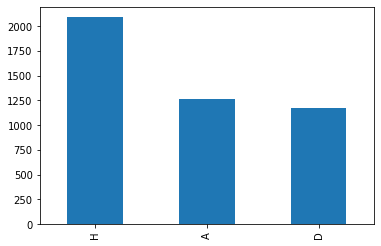

In [37]:
# Count of each outcome for matches
matches.FTR.value_counts().plot(kind = 'bar')

In [38]:
matches.FTR.value_counts()

H    2093
A    1262
D    1171
Name: FTR, dtype: int64

[0, 100, 0, 1500]

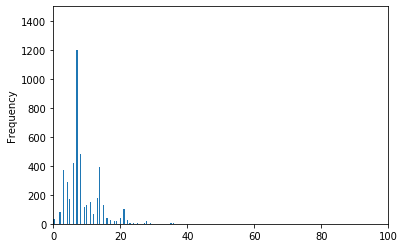

In [39]:
# Count of different amount of home days of rest
matches.Home_Rest.plot(kind = 'hist', bins = 100)
plt.axis([0, 100, 0, 1500])

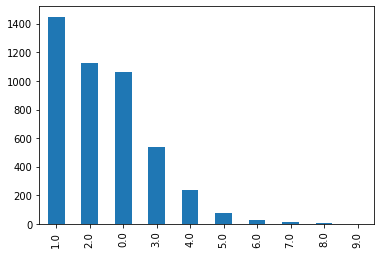

In [40]:
# Count of how many goals are scored as home team
matches.FTHG.value_counts().plot(kind='bar')

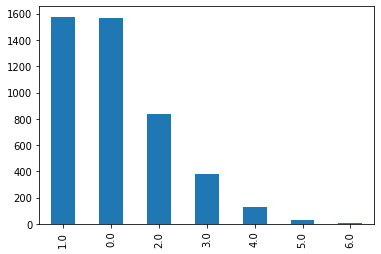

In [41]:
# Count of how many goals are scored as away team
matches.FTAG.value_counts().plot(kind='bar',sort_columns = False)

## 7. Modeling - Method 1

I am exploring predicting home team win, away team win or draw

#### 7a) KNN

In [42]:
matches.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,...,Home_Previous_Relegation,Away_Previous_Relegation,Home_Rest,Away_Rest,Home_Previous_Win,Away_Previous_Win,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points
0,Chelsea,West Ham United,4.0,2.0,H,Graham Barber,65,53,34,55,...,0,0,15,15,0,0,0,0,0,0
1,Coventry City,Middlesbrough,1.0,3.0,A,Barry Knight,44,47,54,52,...,0,0,15,15,0,0,0,0,0,0
2,Derby County,Southampton,2.0,2.0,D,Andy D'Urso,38,44,57,44,...,0,0,15,15,0,0,0,0,0,0
3,Leeds United,Everton,2.0,0.0,H,Dermot Gallagher,69,58,43,50,...,0,0,15,15,0,0,0,0,0,0
4,Leicester City,Aston Villa,0.0,0.0,D,Mike Riley,55,55,55,58,...,0,0,15,15,0,0,0,0,0,0


In [43]:
# Train and testing sets
# Predict home win, away win, draw
#   - Target variable is FTR
#   - Features can't include FT home goals, FT away goals, HT home goals, HT away goals and HT result

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Create arrays for the features and the response variable
target = matches.FTR
features = matches.drop(['FTR', 'FTHG', 'FTAG'], axis = 1)

# Creates binary columns from our categorical columns
features = pd.get_dummies(features, drop_first = True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state=2)

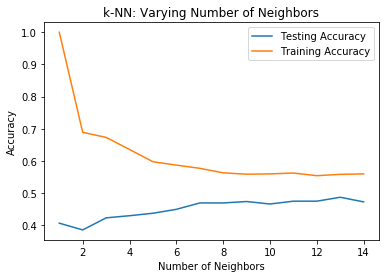

Highest Testing Accuracy: 0.4867549668874172 using 13 neighbors


In [44]:
# Train and Test KNN searching over different n neighbors

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 15)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

print('Highest Testing Accuracy:' , test_accuracy.max(), 'using', test_accuracy.argmax(axis=0) + 1, 'neighbors')

#### 7b) Decision Tree

In [45]:
# Import necessary packages
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

In [46]:
# Parameters to search over
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

In [47]:
# Create decision tree classifier with cross validation
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

In [48]:
# Train model
tree_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, None],
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a20709c10>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a204af690>})

In [49]:
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 4, 'min_samples_leaf': 7}
Best score is 0.49530386740331495


[[ 458   18  532]
 [ 253   36  652]
 [ 283   23 1365]]


0.5066225165562914

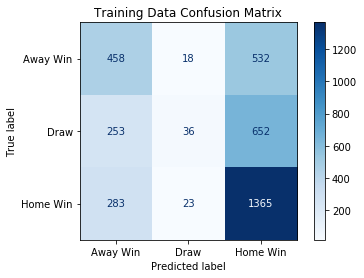

In [50]:
# Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(tree_cv, X_train, y_train,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Training Data Confusion Matrix')
print(disp.confusion_matrix)
tree_cv.score(X_test, y_test)

[[124   6 124]
 [ 57   5 168]
 [ 83   9 330]]


0.5066225165562914

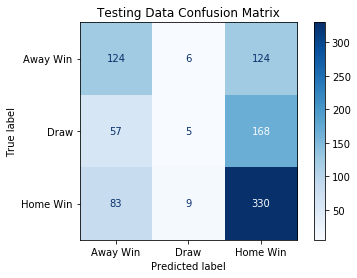

In [51]:
# Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(tree_cv, X_test, y_test,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Testing Data Confusion Matrix')
print(disp.confusion_matrix)
tree_cv.score(X_test, y_test)

In [52]:
# Training Accuracy
tree_cv.score(X_train, y_train)

0.5135359116022099

In [53]:
# Testing Accuracy
tree_cv.score(X_test, y_test)

0.5066225165562914

#### 7c) Random Forest

In [54]:
# Import necessary packages
from sklearn.ensemble import RandomForestClassifier

In [55]:
# Create Random Forest classifier
rf = RandomForestClassifier(n_estimators=25,random_state=2)

In [56]:
# Train model
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=25, random_state=2)

[[1006    0    2]
 [   1  940    0]
 [   1    0 1670]]


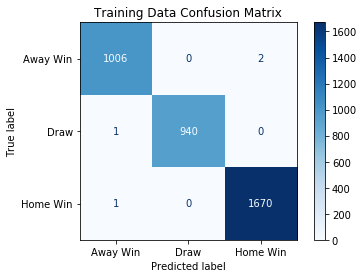

In [57]:
# Create training data confusion matrix
disp = plot_confusion_matrix(rf, X_train, y_train,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Training Data Confusion Matrix')
print(disp.confusion_matrix)

[[109  40 105]
 [ 62  42 126]
 [ 66  42 314]]


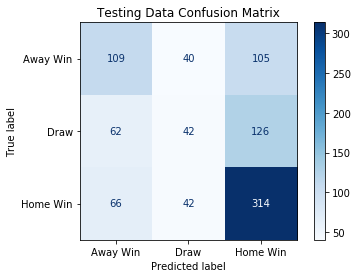

In [58]:
# Create testing data confusion matrix
disp = plot_confusion_matrix(rf, X_test, y_test,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Testing Data Confusion Matrix')
print(disp.confusion_matrix)

In [59]:
# Training Accuracy
rf.score(X_train, y_train)

0.9988950276243094

In [60]:
# Testing Accuracy
rf.score(X_test, y_test)

0.5132450331125827

We can see the model is overfitting to the training data since the training accuracy is almost 100%.

#### 7d) Random Forest with Grid Search

In [61]:
# Import necessary packages
from sklearn.model_selection import GridSearchCV

# Parameters to search over
params_dt = {'n_estimators': [25, 100, 350, 500],
             'min_samples_leaf': [2, 3, 4, 5, 10]}

# Initialize random forest classifier
rf2 = RandomForestClassifier(random_state = 10)

In [62]:
# Creating random forest cross validation model
rf_cv = GridSearchCV(estimator=rf2,
                       param_grid = params_dt,
                      # scoring='roc_auc',
                       cv = 5,
                       n_jobs = -1)

In [63]:
# Training the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 3, 4, 5, 10],
                         'n_estimators': [25, 100, 350, 500]})

In [64]:
# Looking at the best model
rf_cv.best_params_

{'min_samples_leaf': 10, 'n_estimators': 350}

In [65]:
rf_cv_best = rf_cv.best_estimator_

[[ 481    0  527]
 [ 206   15  720]
 [ 156    0 1515]]


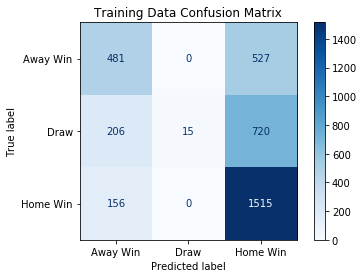

In [66]:
# Create training data confusion matrix
disp = plot_confusion_matrix(rf_cv_best, X_train, y_train,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Training Data Confusion Matrix')
print(disp.confusion_matrix)

[[114   0 140]
 [ 42   0 188]
 [ 52   0 370]]


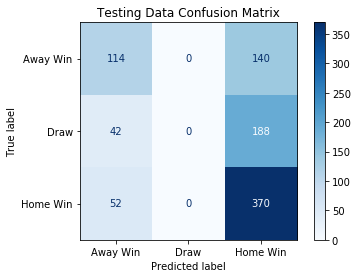

In [67]:
# Create testing data confusion matrix
disp = plot_confusion_matrix(rf_cv_best, X_test, y_test,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Testing Data Confusion Matrix')
print(disp.confusion_matrix)

In [68]:
# Training accuracy
rf_cv.score(X_train, y_train)

0.5555248618784531

In [69]:
# Testing accuracy
rf_cv.score(X_test, y_test)

0.5342163355408388

[[20  0 11]
 [ 5  0 13]
 [ 9  0 44]]


0.6274509803921569

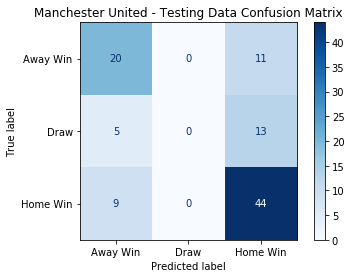

In [70]:
# Looking at strictly Manchester United games out of curiosity

disp = plot_confusion_matrix(rf_cv_best, X_test[(X_test['AwayTeam_Manchester United']== 1) | (X_test['HomeTeam_Manchester United']== 1)], 
                             y_test[X_test[(X_test['AwayTeam_Manchester United']== 1) | (X_test['HomeTeam_Manchester United']== 1)].index],
                             display_labels = ['Away Win', 'Draw', 'Home Win'], 
                             cmap = plt.cm.Blues)

disp.ax_.set_title('Manchester United - Testing Data Confusion Matrix')
print(disp.confusion_matrix)

# Testing accuracy of Manchester United games
rf_cv_best.score(X_test[(X_test['AwayTeam_Manchester United']== 1) | (X_test['HomeTeam_Manchester United']== 1)],
                 y_test[X_test[(X_test['AwayTeam_Manchester United']== 1) | (X_test['HomeTeam_Manchester United']== 1)].index])



In [71]:
# Look at importance of features
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rf_cv_best.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Home_Last_Goals_F    Importance: 0.12
Variable: Away_Last_Pts        Importance: 0.11
Variable: Home_Last_Pts        Importance: 0.1
Variable: Home_Last_Goals_A    Importance: 0.1
Variable: Away_Last_Goals_F    Importance: 0.1
Variable: Away_Last_Goals_A    Importance: 0.09
Variable: Home_Current_Points  Importance: 0.05
Variable: Away_Current_Points  Importance: 0.05
Variable: Home_Rest            Importance: 0.03
Variable: Away_Rest            Importance: 0.03
Variable: AwayTeam_Manchester United Importance: 0.02
Variable: HomeTeam_Aston Villa Importance: 0.01
Variable: HomeTeam_Chelsea     Importance: 0.01
Variable: HomeTeam_Liverpool   Importance: 0.01
Variable: HomeTeam_Manchester City Importance: 0.01
Variable: HomeTeam_Manchester United Importance: 0.01
Variable: HomeTeam_Sunderland  Importance: 0.01
Variable: AwayTeam_Chelsea     Importance: 0.01
Variable: Referee_M Dean       Importance: 0.01
Variable: Home_2_Previous_Win_1 Importance: 0.01
Variable: Away_2_Previous_

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Referee has very little importance to the model. This is very good to see as we don't want referees in real life influencing the outcomes of games. 

### 7e) Final Random Forest Model

In [72]:
del matches['Referee']

In [73]:
# Create arrays for the features and the response variable
target = matches.FTR.reset_index(drop=True)
features = matches.drop(['FTR', 'FTHG', 'FTAG'], axis = 1).reset_index(drop=True)

# Creates binary columns from our categorical columns
features = pd.get_dummies(features, drop_first = True)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .2, random_state=2, stratify=target)

In [74]:
# Parameters to search over
params_dt = {'n_estimators': [25, 100, 350, 500],
             'min_samples_leaf': [2, 3, 4, 5, 10]}

# Creating random forest cross validation model
rf_cv = GridSearchCV(estimator=rf2,
                       param_grid = params_dt,
                       cv = 5,
                       n_jobs = -1)

In [75]:
# Training the model
rf_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=10), n_jobs=-1,
             param_grid={'min_samples_leaf': [2, 3, 4, 5, 10],
                         'n_estimators': [25, 100, 350, 500]})

In [76]:
# Parameters for best model
rf_cv_best = rf_cv.best_estimator_
rf_cv.best_params_

{'min_samples_leaf': 5, 'n_estimators': 500}

[[ 672    4  333]
 [ 160  323  454]
 [ 117    0 1557]]


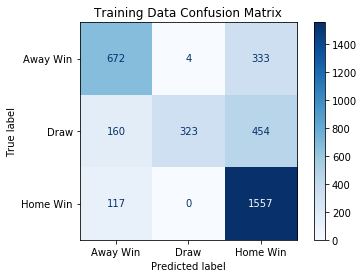

In [77]:
# Create training data confusion matrix
disp = plot_confusion_matrix(rf_cv_best, X_train, y_train,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Training Data Confusion Matrix')
print(disp.confusion_matrix)

[[123   6 124]
 [ 59   6 169]
 [ 59   8 352]]


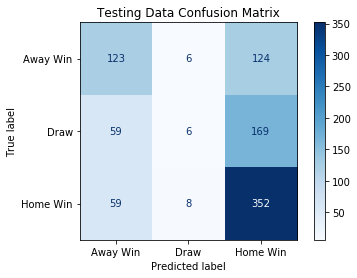

In [78]:
# Create testing data confusion matrix
disp = plot_confusion_matrix(rf_cv_best, X_test, y_test,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Testing Data Confusion Matrix')
print(disp.confusion_matrix)

In [79]:
# Training accuracy
rf_cv_best.score(X_train, y_train)

0.7049723756906078

In [80]:
# Testing accuracy
rf_cv_best.score(X_test, y_test)

0.5309050772626932

In [81]:
# Look at how many upsets occur. Home wins with less points than away and away wins with less points than home
y_pred = pd.DataFrame(rf_cv_best.predict(X_test), columns = ['Prediction'])

X_test2 = X_test.reset_index(drop = True)
X_test2 = X_test2.merge(y_pred, left_index = True, right_index = True)

In [82]:
# Predicting home team upsets
X_test2[(X_test2.Home_Last_Pts < X_test2.Away_Last_Pts) & (X_test2.Prediction == 'H')]

,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,Away_Last_Goals_A,Home_Rest,Away_Rest,Home_Current_Points,Away_Current_Points,...,AwayTeam_Watford,AwayTeam_West Bromwich Albion,AwayTeam_West Ham United,AwayTeam_Wigan,AwayTeam_Wolverhampton Wanderers,Home_Previous_Win_1,Away_Previous_Win_1,Home_2_Previous_Win_1,Away_2_Previous_Win_1,Prediction
2,39,38,60,50,43,41,5,8,34,28,...,0,0,0,0,0,0,0,0,0,H
3,76,67,28,87,80,22,13,19,4,1,...,0,0,0,0,0,0,1,1,0,H
8,44,36,44,71,74,52,7,7,55,61,...,0,0,0,0,0,0,0,0,0,H
9,42,40,61,49,49,43,7,6,12,13,...,0,0,0,0,0,0,0,0,0,H
10,64,65,46,89,89,33,8,8,10,12,...,0,0,0,0,0,0,0,1,1,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
879,40,29,51,53,48,57,13,21,14,7,...,0,0,1,0,0,0,1,1,0,H
882,43,45,57,44,36,44,6,5,10,8,...,0,0,0,0,0,0,0,1,1,H
893,67,51,30,91,97,45,13,14,51,44,...,0,0,0,0,0,0,0,0,0,H
895,45,47,64,46,41,48,21,28,42,32,...,0,0,0,0,0,0,0,0,0,H


In [83]:
# Predicting away team upsets
X_test2[(X_test2.Away_Last_Pts < X_test2.Home_Last_Pts) & (X_test2.Prediction == 'A')]

,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,Away_Last_Goals_A,Home_Rest,Away_Rest,Home_Current_Points,Away_Current_Points,...,AwayTeam_Watford,AwayTeam_West Bromwich Albion,AwayTeam_West Ham United,AwayTeam_Wigan,AwayTeam_Wolverhampton Wanderers,Home_Previous_Win_1,Away_Previous_Win_1,Home_2_Previous_Win_1,Away_2_Previous_Win_1,Prediction
53,66,53,37,64,66,38,2,2,15,23,...,0,0,0,0,0,0,0,0,0,A
287,51,41,55,50,59,53,10,12,41,38,...,0,0,0,0,0,0,1,0,0,A
890,53,48,57,46,55,51,7,18,28,32,...,0,0,0,0,0,0,0,0,0,A


We can see that the model predicts 205 "upsets" when the home team performed worse than the away team the previous year and still won. On the other hand, it only predicts 3 "upset" when the away team performed worse the previous year than the home team and still won. 

We also see that the model only predicts a total of 20 draws in the testing dataset. In reality, we see 234 draws in the testing dataset.

### 7f) Neural Network

In [84]:
# Import necessary packages
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [85]:
# Initiate sequential model
model = Sequential()

# Add Layers
model.add(Dense(300, activation='relu', input_shape=(86,)))
model.add(BatchNormalization())
model.add(Dense(300, activation='relu', input_shape=(86,)))
model.add(BatchNormalization())
model.add(Dense(300, activation='relu', input_shape=(86,)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [86]:
# Split data into training and testing sets
#X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(features, target,test_size = .25, random_state=2)

# Create binary columns for categorical features
#y_train_NN = pd.get_dummies(y_train_NN)
#y_test_NN = pd.get_dummies(y_test_NN)

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [87]:
# Import the early stopping callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Define a callback to monitor val_acc
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=10)

model_Checkpoint = ModelCheckpoint('best_model', save_best_only = True)


In [88]:
#model.fit(X_train_NN, y_train_NN, epochs=30, callbacks=[monitor_val_acc, model_Checkpoint], 
#          validation_data = (X_test_NN, y_test_NN))
model.fit(X_train, y_train, epochs=30, callbacks=[monitor_val_acc, model_Checkpoint], 
          validation_data = (X_test, y_test))

Train on 3620 samples, validate on 906 samples
Epoch 1/30
3620/3620 [==============================] - 8s 2ms/step - loss: 1.2446 - accuracy: 0.4412 - val_loss: 1.1626 - val_accuracy: 0.4514
Epoch 2/30
3620/3620 [==============================] - 3s 787us/step - loss: 1.0533 - accuracy: 0.4812 - val_loss: 1.1556 - val_accuracy: 0.4018
Epoch 3/30
3620/3620 [==============================] - 3s 766us/step - loss: 1.0387 - accuracy: 0.4790 - val_loss: 1.0804 - val_accuracy: 0.4570
Epoch 4/30
3620/3620 [==============================] - 3s 898us/step - loss: 1.0148 - accuracy: 0.5077 - val_loss: 1.0421 - val_accuracy: 0.4923
Epoch 5/30
3620/3620 [==============================] - 3s 772us/step - loss: 1.0086 - accuracy: 0.5116 - val_loss: 1.0449 - val_accuracy: 0.4901
Epoch 6/30
3620/3620 [==============================] - 3s 776us/step - loss: 0.9984 - accuracy: 0.5124 - val_loss: 1.0432 - val_accuracy: 0.4845
Epoch 7/30
3620/3620 [==============================] - 3s 817us/step - loss: 1

In [89]:
#model.evaluate(X_test_NN, y_test_NN)[1]
model.evaluate(X_test, y_test)[1]

906/906 [==============================] - 0s 407us/step


0.4459161162376404

In [90]:
# Taking predictions and turning into predicted outcome string
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

pred_outcome = np.empty(shape=(len(y_pred),1),dtype='object')

for i in range(len(y_pred)):
    
    if np.argmax(Y_pred[i], axis=0) == [0]:
        pred_outcome[i] = 'A'
        
    if np.argmax(Y_pred[i], axis=0) == [1]:
        pred_outcome[i] = 'D'
        
    if np.argmax(Y_pred[i], axis=0) == [2]:
        pred_outcome[i] = 'H'


In [91]:
# Confusion matrix 
print('Confusion Matrix')
print(confusion_matrix(target.iloc[X_test.index], pred_outcome))
print('Classification Report')
target_names = ['Away', 'Draw', 'Home']
print(classification_report(target.iloc[X_test.index], pred_outcome, target_names=target_names))

Confusion Matrix
[[103  29 121]
 [ 73  24 137]
 [ 92  50 277]]
Classification Report
              precision    recall  f1-score   support

        Away       0.38      0.41      0.40       253
        Draw       0.23      0.10      0.14       234
        Home       0.52      0.66      0.58       419

    accuracy                           0.45       906
   macro avg       0.38      0.39      0.37       906
weighted avg       0.41      0.45      0.42       906



In [92]:
# Number of predictions for each type of outcome
pd.Series(pd.Index(pred_outcome)).value_counts()

(H,)    535
(A,)    268
(D,)    103
dtype: int64

## 8. Modeling - Method 2

In this method, I plan to predict each team's goals scored and allowed and then use that as an input into another  model to predict the final outcome.

In [93]:
matches.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,...,Home_Previous_Relegation,Away_Previous_Relegation,Home_Rest,Away_Rest,Home_Previous_Win,Away_Previous_Win,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points
0,Chelsea,West Ham United,4.0,2.0,H,65,53,34,55,52,...,0,0,15,15,0,0,0,0,0,0
1,Coventry City,Middlesbrough,1.0,3.0,A,44,47,54,52,46,...,0,0,15,15,0,0,0,0,0,0
2,Derby County,Southampton,2.0,2.0,D,38,44,57,44,45,...,0,0,15,15,0,0,0,0,0,0
3,Leeds United,Everton,2.0,0.0,H,69,58,43,50,59,...,0,0,15,15,0,0,0,0,0,0
4,Leicester City,Aston Villa,0.0,0.0,D,55,55,55,58,46,...,0,0,15,15,0,0,0,0,0,0


In [94]:
# Drop rows with null values
matches = matches.dropna(axis = 0)
matches.isna().sum().sum()

0

In [95]:
matches.dtypes

HomeTeam                    category
AwayTeam                    category
FTHG                         float64
FTAG                         float64
FTR                           object
Home_Last_Pts                  int64
Home_Last_Goals_F              int64
Home_Last_Goals_A              int64
Away_Last_Pts                  int64
Away_Last_Goals_F              int64
Away_Last_Goals_A              int64
Home_Previous_Relegation    category
Away_Previous_Relegation    category
Home_Rest                      int64
Away_Rest                      int64
Home_Previous_Win           category
Away_Previous_Win           category
Home_2_Previous_Win         category
Away_2_Previous_Win         category
Home_Current_Points            int64
Away_Current_Points            int64
dtype: object

In [96]:
# Change data types
matches.HomeTeam = matches.HomeTeam.astype('category')
matches.AwayTeam = matches.AwayTeam.astype('category')
matches.FTR = matches.FTR.astype('str')
#matches.Referee = matches.Referee.astype('category')
matches.Home_Last_Pts = matches.Home_Last_Pts.astype(int)
matches.Away_Last_Pts = matches.Away_Last_Pts.astype(int)
matches.Home_Last_Goals_F = matches.Home_Last_Goals_F.astype(int)
matches.Away_Last_Goals_F = matches.Away_Last_Goals_F.astype(int)
matches.Home_Last_Goals_A = matches.Home_Last_Goals_A.astype(int)
matches.Away_Last_Goals_A = matches.Away_Last_Goals_A.astype(int)
matches.Home_Previous_Relegation = matches.Home_Previous_Relegation.astype('category')
matches.Away_Previous_Relegation = matches.Away_Previous_Relegation.astype('category')
matches.FTHG = matches.FTHG.astype(int)
matches.FTAG = matches.FTAG.astype(int)

In [97]:
# Creating training and testing data sets

target_FTHG = matches.FTHG
target_FTAG = matches.FTAG
final_target = matches.FTR

features = matches.drop(['FTR', 'FTHG', 'FTAG'], axis = 1)

features = pd.get_dummies(features, drop_first = True)

X_train_FTHG, X_test_FTHG, y_train_FTHG, y_test_FTHG = train_test_split(features, target_FTHG, test_size = .25, random_state=2)
X_train_FTAG, X_test_FTAG, y_train_FTAG, y_test_FTAG = train_test_split(features, target_FTAG, test_size = .25, random_state=2)


In [98]:
# Initializing Linear Regression Model and fitting

from sklearn.linear_model import LinearRegression

reg_FTHG = LinearRegression().fit(X_train_FTHG, y_train_FTHG)
reg_FTAG = LinearRegression().fit(X_train_FTAG, y_train_FTAG)

In [99]:
# Poisson Regression Model
from statsmodels.genmod.families import Poisson
import statsmodels.api as sm

sm_glm_H = sm.GLM(y_train_FTHG, X_train_FTHG, family = Poisson())
pos_fit_H = sm_glm_H.fit()

sm_glm_A = sm.GLM(y_train_FTAG, X_train_FTAG, family = Poisson())
pos_fit_A = sm_glm_A.fit()

In [100]:
# Random Forest Models
from sklearn.ensemble import RandomForestRegressor

# Initialize random forest classifier
rf_H_A = RandomForestRegressor(random_state = 10)

# Parameters to search over
params = {'n_estimators': [25, 100, 350, 500, 750, 1000],
             'min_samples_leaf': [2, 3, 4, 5, 10]}

# Creating random forest cross validation model
rf_H_A_cv = GridSearchCV(estimator=rf_H_A,
                       param_grid = params,
                       cv = 5,
                       n_jobs = -1)

In [101]:
rf_H_A_cv.fit(X_train_FTHG, y_train_FTHG)
rf_cv_H = rf_H_A_cv.best_estimator_

In [102]:
rf_H_A_cv.fit(X_train_FTAG, y_train_FTAG)
rf_cv_A = rf_H_A_cv.best_estimator_

In [103]:
# Random Forest
pred_train_FTHG_rf = rf_cv_H.predict(X_train_FTHG)
pred_train_FTAG_rf = rf_cv_A.predict(X_train_FTAG)

pred_test_FTHG_rf = rf_cv_H.predict(X_test_FTHG)
pred_test_FTAG_rf = rf_cv_A.predict(X_test_FTAG)

# Poisson
pred_train_FTHG_pos = pos_fit_H.predict(X_train_FTHG)
pred_train_FTAG_pos = pos_fit_A.predict(X_train_FTAG)

pred_test_FTHG_pos = pos_fit_H.predict(X_test_FTHG)
pred_test_FTAG_pos = pos_fit_A.predict(X_test_FTAG)

# Linear
pred_test_FTHG_lin = reg_FTHG.predict(X_test_FTHG)
pred_test_FTAG_lin = reg_FTAG.predict(X_test_FTAG)

pred_train_FTHG_lin = reg_FTHG.predict(X_train_FTHG)
pred_train_FTAG_lin = reg_FTAG.predict(X_train_FTAG)

In [104]:
# Random Forest Predictions to DataFrame
pred_train_FTHG_rf = pd.DataFrame(pred_train_FTHG_rf.reshape(-1,1), index = X_train_FTHG.index)
pred_train_FTAG_rf = pd.DataFrame(pred_train_FTAG_rf.reshape(-1,1), index = X_train_FTAG.index)

pred_test_FTHG_rf = pd.DataFrame(pred_test_FTHG_rf.reshape(-1,1), index = X_test_FTHG.index)
pred_test_FTAG_rf = pd.DataFrame(pred_test_FTAG_rf.reshape(-1,1), index = X_test_FTAG.index)

# Poisson Predictions to DataFrame
pred_train_FTHG_pos = pd.DataFrame(pred_train_FTHG_pos, index = X_train_FTHG.index)
pred_train_FTAG_pos = pd.DataFrame(pred_train_FTAG_pos, index = X_train_FTAG.index)

pred_test_FTHG_pos = pd.DataFrame(pred_test_FTHG_pos, index = X_test_FTHG.index)
pred_test_FTAG_pos = pd.DataFrame(pred_test_FTAG_pos, index = X_test_FTAG.index)

# Linear Predictions to DataFrame
pred_train_FTHG_lin = pd.DataFrame(pred_train_FTHG_lin.reshape(-1,1), index = X_train_FTHG.index)
pred_train_FTAG_lin = pd.DataFrame(pred_train_FTAG_lin.reshape(-1,1), index = X_train_FTAG.index)

pred_test_FTHG_lin = pd.DataFrame(pred_test_FTHG_lin.reshape(-1,1), index = X_test_FTHG.index)
pred_test_FTAG_lin = pd.DataFrame(pred_test_FTAG_lin.reshape(-1,1), index = X_test_FTAG.index)

In [105]:
# Random Forest Prediction
pred_goals_scored_FTHG_rf = pred_train_FTHG_rf.append(pred_test_FTHG_rf)
pred_goals_scored_FTAG_rf = pred_train_FTAG_rf.append(pred_test_FTAG_rf)

pred_goals_scored_FTHG_rf.columns = ['Pred_FTHG_RF']
pred_goals_scored_FTAG_rf.columns = ['Pred_FTAG_RF']

pred_goals_scored_rf = pred_goals_scored_FTHG_rf.merge(pred_goals_scored_FTAG_rf, left_index = True, right_index = True)

# Poisson Prediction
pred_goals_scored_FTHG_pos = pred_train_FTHG_pos.append(pred_test_FTHG_pos)
pred_goals_scored_FTAG_pos = pred_train_FTAG_pos.append(pred_test_FTAG_pos)

pred_goals_scored_FTHG_pos.columns = ['Pred_FTHG_Pos']
pred_goals_scored_FTAG_pos.columns = ['Pred_FTAG_Pos']

pred_goals_scored_pos = pred_goals_scored_FTHG_pos.merge(pred_goals_scored_FTAG_pos, left_index = True, right_index = True)\

# Linear Prediction
pred_goals_scored_FTHG_lin = pred_train_FTHG_lin.append(pred_test_FTHG_lin)
pred_goals_scored_FTAG_lin = pred_train_FTAG_lin.append(pred_test_FTAG_lin)

pred_goals_scored_FTHG_lin.columns = ['Pred_FTHG_Lin']
pred_goals_scored_FTAG_lin.columns = ['Pred_FTAG_Lin']

pred_goals_scored_lin = pred_goals_scored_FTHG_lin.merge(pred_goals_scored_FTAG_lin, left_index = True, right_index = True)\

In [106]:
# Merge RF, Poisson, Linear Predictions to original DataFrame
matches = matches.merge(pred_goals_scored_rf, left_index = True, right_index = True)
matches = matches.merge(pred_goals_scored_pos, left_index = True, right_index = True)
matches = matches.merge(pred_goals_scored_lin, left_index = True, right_index = True)

In [107]:
matches.head()

,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Home_Last_Pts,Home_Last_Goals_F,Home_Last_Goals_A,Away_Last_Pts,Away_Last_Goals_F,...,Home_2_Previous_Win,Away_2_Previous_Win,Home_Current_Points,Away_Current_Points,Pred_FTHG_RF,Pred_FTAG_RF,Pred_FTHG_Pos,Pred_FTAG_Pos,Pred_FTHG_Lin,Pred_FTAG_Lin
0,Chelsea,West Ham United,4,2,H,65,53,34,55,52,...,0,0,0,0,2.061627,1.370635,1.873383,0.723228,1.893024,0.704659
1,Coventry City,Middlesbrough,1,3,A,44,47,54,52,46,...,0,0,0,0,1.221651,1.614510,0.517490,1.245069,0.351177,1.272037
2,Derby County,Southampton,2,2,D,38,44,57,44,45,...,0,0,0,0,1.161933,0.973251,1.191441,0.796726,1.168024,0.760664
3,Leeds United,Everton,2,0,H,69,58,43,50,59,...,0,0,0,0,1.782198,1.315149,1.595445,1.511099,1.602246,1.519581
4,Leicester City,Aston Villa,0,0,D,55,55,55,58,46,...,0,0,0,0,1.357303,1.027496,1.587519,1.183326,1.602452,1.168060


### 8a) Re-feed Goal Prediction into another Random Forest Model

In [109]:
# Creating training and testing data sets

target_final = matches.FTR

features = matches.drop(['FTR', 'FTHG', 'FTAG'], axis = 1)

features = pd.get_dummies(features, drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(features, target_final, test_size = .25, random_state=2)

In [110]:
# Initialize random forest classifier
rf3 = RandomForestClassifier(random_state = 10, class_weight={'A':1,'D':1, 'H':1})

# Parameters to search over
params_dt3 = {'n_estimators': [25, 100, 350, 500, 750, 1000],
             'min_samples_leaf': [3, 4, 5, 10]}

# Creating random forest cross validation model
rf3_cv = GridSearchCV(estimator=rf3,
                       param_grid = params_dt3,
                       cv = 5,
                       n_jobs = -1)

In [111]:
rf3_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={'A': 1, 'D': 1,
                                                            'H': 1},
                                              random_state=10),
             n_jobs=-1,
             param_grid={'min_samples_leaf': [3, 4, 5, 10],
                         'n_estimators': [25, 100, 350, 500, 750, 1000]})

In [112]:
rf3_cv_best = rf3_cv.best_estimator_

In [113]:
rf3_cv.best_params_

{'min_samples_leaf': 3, 'n_estimators': 350}

[[ 877    3   56]
 [  31  742  104]
 [  23    2 1556]]


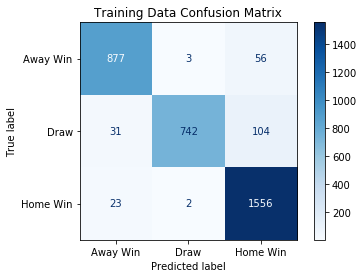

In [114]:
# Create training data confusion matrix
disp = plot_confusion_matrix(rf3_cv_best, X_train, y_train,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Training Data Confusion Matrix')
print(disp.confusion_matrix)

[[157  25 144]
 [ 71  36 187]
 [ 83  38 391]]


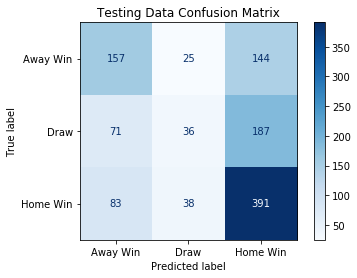

In [115]:
# Create testing data confusion matrix
disp = plot_confusion_matrix(rf3_cv_best, X_test, y_test,
                                 display_labels = ['Away Win', 'Draw', 'Home Win'], 
                                 cmap = plt.cm.Blues)

disp.ax_.set_title('Testing Data Confusion Matrix')
print(disp.confusion_matrix)

In [116]:
# Training accuracy
print(rf3_cv_best.score(X_train, y_train))

# Testing accuracy
print(rf3_cv_best.score(X_test, y_test))

0.9354743665291692
0.5159010600706714


Still no significant increase in accuracy.

### 8b) Re-feed Goal Prediction into another Neural Network

In [117]:
# Creating training and testing data sets

target_FTHG = matches.FTHG.reset_index(drop=True)
target_FTAG = matches.FTAG.reset_index(drop=True)
final_target = matches.FTR.reset_index(drop=True)

features = matches.drop(['FTR', 'FTHG', 'FTAG'], axis = 1).reset_index(drop=True)

features = pd.get_dummies(features, drop_first = True).reset_index(drop=True)



X_train_NN_FTHG, X_test_NN_FTHG, y_train_NN_FTHG, y_test_NN_FTHG = train_test_split(features, 
                                                                                    target_FTHG, test_size = .25, 
                                                                                    random_state=2)
X_train_NN_FTAG, X_test_NN_FTAG, y_train_NN_FTAG, y_test_NN_FTAG = train_test_split(features, 
                                                                                    target_FTAG, test_size = .25, 
                                                                                    random_state=2)

In [118]:
# Correct Order of Columns
X_train_NN_FTHG = X_train_NN_FTHG[['Home_Last_Pts','Home_Last_Goals_F', 'Home_Last_Goals_A', 'Away_Last_Pts',
 'Away_Last_Goals_F', 'Away_Last_Goals_A', 'Home_Rest', 'Away_Rest', 'Home_Current_Points', 'Away_Current_Points',
 'HomeTeam_Aston Villa', 'HomeTeam_Birmingham City', 'HomeTeam_Blackburn Rovers', 'HomeTeam_Bolton Wanderers',
 'HomeTeam_Bournemouth', 'HomeTeam_Bradford City', 'HomeTeam_Burnley', 'HomeTeam_Charlton Athletic',
 'HomeTeam_Chelsea', 'HomeTeam_Coventry City', 'HomeTeam_Crystal Palace', 'HomeTeam_Derby County', 'HomeTeam_Everton',
 'HomeTeam_Fulham', 'HomeTeam_Hull City', 'HomeTeam_Leeds United', 'HomeTeam_Leicester City', 'HomeTeam_Liverpool',
 'HomeTeam_Manchester City', 'HomeTeam_Manchester United', 'HomeTeam_Middlesbrough', 'HomeTeam_Newcastle United',
 'HomeTeam_Norwich City', 'HomeTeam_Portsmouth', 'HomeTeam_Queens Park Rangers', 'HomeTeam_Reading',
 'HomeTeam_Southampton', 'HomeTeam_Stoke City', 'HomeTeam_Sunderland', 'HomeTeam_Swansea City',
 'HomeTeam_Tottenham Hotspurs', 'HomeTeam_Watford', 'HomeTeam_West Bromwich Albion', 'HomeTeam_West Ham United',
 'HomeTeam_Wigan', 'HomeTeam_Wolverhampton Wanderers', 'AwayTeam_Aston Villa', 'AwayTeam_Birmingham City',
 'AwayTeam_Blackburn Rovers', 'AwayTeam_Bolton Wanderers', 'AwayTeam_Bournemouth', 'AwayTeam_Bradford City',
 'AwayTeam_Burnley', 'AwayTeam_Charlton Athletic', 'AwayTeam_Chelsea', 'AwayTeam_Coventry City',
 'AwayTeam_Crystal Palace', 'AwayTeam_Derby County', 'AwayTeam_Everton', 'AwayTeam_Fulham', 'AwayTeam_Hull City',
 'AwayTeam_Leeds United', 'AwayTeam_Leicester City', 'AwayTeam_Liverpool', 'AwayTeam_Manchester City',
 'AwayTeam_Manchester United', 'AwayTeam_Middlesbrough', 'AwayTeam_Newcastle United', 'AwayTeam_Norwich City',
 'AwayTeam_Portsmouth', 'AwayTeam_Queens Park Rangers', 'AwayTeam_Reading', 'AwayTeam_Southampton',
 'AwayTeam_Stoke City', 'AwayTeam_Sunderland', 'AwayTeam_Swansea City', 'AwayTeam_Tottenham Hotspurs',
 'AwayTeam_Watford', 'AwayTeam_West Bromwich Albion', 'AwayTeam_West Ham United', 'AwayTeam_Wigan',
 'AwayTeam_Wolverhampton Wanderers', 'Home_Previous_Win_1', 'Away_Previous_Win_1', 'Home_2_Previous_Win_1',
 'Away_2_Previous_Win_1', 'Pred_FTHG_RF', 'Pred_FTAG_RF', 'Pred_FTHG_Pos', 'Pred_FTAG_Pos', 'Pred_FTHG_Lin',
 'Pred_FTAG_Lin']]

In [119]:
# Correct Order of Columns
X_train_NN_FTAG = X_train_NN_FTAG[['Home_Last_Pts','Home_Last_Goals_F', 'Home_Last_Goals_A', 'Away_Last_Pts',
 'Away_Last_Goals_F', 'Away_Last_Goals_A', 'Home_Rest', 'Away_Rest', 'Home_Current_Points', 'Away_Current_Points',
 'HomeTeam_Aston Villa', 'HomeTeam_Birmingham City', 'HomeTeam_Blackburn Rovers', 'HomeTeam_Bolton Wanderers',
 'HomeTeam_Bournemouth', 'HomeTeam_Bradford City', 'HomeTeam_Burnley', 'HomeTeam_Charlton Athletic',
 'HomeTeam_Chelsea', 'HomeTeam_Coventry City', 'HomeTeam_Crystal Palace', 'HomeTeam_Derby County', 'HomeTeam_Everton',
 'HomeTeam_Fulham', 'HomeTeam_Hull City', 'HomeTeam_Leeds United', 'HomeTeam_Leicester City', 'HomeTeam_Liverpool',
 'HomeTeam_Manchester City', 'HomeTeam_Manchester United', 'HomeTeam_Middlesbrough', 'HomeTeam_Newcastle United',
 'HomeTeam_Norwich City', 'HomeTeam_Portsmouth', 'HomeTeam_Queens Park Rangers', 'HomeTeam_Reading',
 'HomeTeam_Southampton', 'HomeTeam_Stoke City', 'HomeTeam_Sunderland', 'HomeTeam_Swansea City',
 'HomeTeam_Tottenham Hotspurs', 'HomeTeam_Watford', 'HomeTeam_West Bromwich Albion', 'HomeTeam_West Ham United',
 'HomeTeam_Wigan', 'HomeTeam_Wolverhampton Wanderers', 'AwayTeam_Aston Villa', 'AwayTeam_Birmingham City',
 'AwayTeam_Blackburn Rovers', 'AwayTeam_Bolton Wanderers', 'AwayTeam_Bournemouth', 'AwayTeam_Bradford City',
 'AwayTeam_Burnley', 'AwayTeam_Charlton Athletic', 'AwayTeam_Chelsea', 'AwayTeam_Coventry City',
 'AwayTeam_Crystal Palace', 'AwayTeam_Derby County', 'AwayTeam_Everton', 'AwayTeam_Fulham', 'AwayTeam_Hull City',
 'AwayTeam_Leeds United', 'AwayTeam_Leicester City', 'AwayTeam_Liverpool', 'AwayTeam_Manchester City',
 'AwayTeam_Manchester United', 'AwayTeam_Middlesbrough', 'AwayTeam_Newcastle United', 'AwayTeam_Norwich City',
 'AwayTeam_Portsmouth', 'AwayTeam_Queens Park Rangers', 'AwayTeam_Reading', 'AwayTeam_Southampton',
 'AwayTeam_Stoke City', 'AwayTeam_Sunderland', 'AwayTeam_Swansea City', 'AwayTeam_Tottenham Hotspurs',
 'AwayTeam_Watford', 'AwayTeam_West Bromwich Albion', 'AwayTeam_West Ham United', 'AwayTeam_Wigan',
 'AwayTeam_Wolverhampton Wanderers', 'Home_Previous_Win_1', 'Away_Previous_Win_1', 'Home_2_Previous_Win_1',
 'Away_2_Previous_Win_1', 'Pred_FTHG_RF', 'Pred_FTAG_RF', 'Pred_FTHG_Pos', 'Pred_FTAG_Pos', 'Pred_FTHG_Lin',
 'Pred_FTAG_Lin']]

In [120]:
# Correct Order of Columns
X_test_NN_FTHG = X_test_NN_FTHG[['Home_Last_Pts','Home_Last_Goals_F', 'Home_Last_Goals_A', 'Away_Last_Pts',
 'Away_Last_Goals_F', 'Away_Last_Goals_A', 'Home_Rest', 'Away_Rest', 'Home_Current_Points', 'Away_Current_Points',
 'HomeTeam_Aston Villa', 'HomeTeam_Birmingham City', 'HomeTeam_Blackburn Rovers', 'HomeTeam_Bolton Wanderers',
 'HomeTeam_Bournemouth', 'HomeTeam_Bradford City', 'HomeTeam_Burnley', 'HomeTeam_Charlton Athletic',
 'HomeTeam_Chelsea', 'HomeTeam_Coventry City', 'HomeTeam_Crystal Palace', 'HomeTeam_Derby County', 'HomeTeam_Everton',
 'HomeTeam_Fulham', 'HomeTeam_Hull City', 'HomeTeam_Leeds United', 'HomeTeam_Leicester City', 'HomeTeam_Liverpool',
 'HomeTeam_Manchester City', 'HomeTeam_Manchester United', 'HomeTeam_Middlesbrough', 'HomeTeam_Newcastle United',
 'HomeTeam_Norwich City', 'HomeTeam_Portsmouth', 'HomeTeam_Queens Park Rangers', 'HomeTeam_Reading',
 'HomeTeam_Southampton', 'HomeTeam_Stoke City', 'HomeTeam_Sunderland', 'HomeTeam_Swansea City',
 'HomeTeam_Tottenham Hotspurs', 'HomeTeam_Watford', 'HomeTeam_West Bromwich Albion', 'HomeTeam_West Ham United',
 'HomeTeam_Wigan', 'HomeTeam_Wolverhampton Wanderers', 'AwayTeam_Aston Villa', 'AwayTeam_Birmingham City',
 'AwayTeam_Blackburn Rovers', 'AwayTeam_Bolton Wanderers', 'AwayTeam_Bournemouth', 'AwayTeam_Bradford City',
 'AwayTeam_Burnley', 'AwayTeam_Charlton Athletic', 'AwayTeam_Chelsea', 'AwayTeam_Coventry City',
 'AwayTeam_Crystal Palace', 'AwayTeam_Derby County', 'AwayTeam_Everton', 'AwayTeam_Fulham', 'AwayTeam_Hull City',
 'AwayTeam_Leeds United', 'AwayTeam_Leicester City', 'AwayTeam_Liverpool', 'AwayTeam_Manchester City',
 'AwayTeam_Manchester United', 'AwayTeam_Middlesbrough', 'AwayTeam_Newcastle United', 'AwayTeam_Norwich City',
 'AwayTeam_Portsmouth', 'AwayTeam_Queens Park Rangers', 'AwayTeam_Reading', 'AwayTeam_Southampton',
 'AwayTeam_Stoke City', 'AwayTeam_Sunderland', 'AwayTeam_Swansea City', 'AwayTeam_Tottenham Hotspurs',
 'AwayTeam_Watford', 'AwayTeam_West Bromwich Albion', 'AwayTeam_West Ham United', 'AwayTeam_Wigan',
 'AwayTeam_Wolverhampton Wanderers', 'Home_Previous_Win_1', 'Away_Previous_Win_1', 'Home_2_Previous_Win_1',
 'Away_2_Previous_Win_1', 'Pred_FTHG_RF', 'Pred_FTAG_RF', 'Pred_FTHG_Pos', 'Pred_FTAG_Pos', 'Pred_FTHG_Lin',
 'Pred_FTAG_Lin']]

In [121]:
# Correct Order of Columns
X_test_NN_FTAG = X_test_NN_FTAG[['Home_Last_Pts','Home_Last_Goals_F', 'Home_Last_Goals_A', 'Away_Last_Pts',
 'Away_Last_Goals_F', 'Away_Last_Goals_A', 'Home_Rest', 'Away_Rest', 'Home_Current_Points', 'Away_Current_Points',
 'HomeTeam_Aston Villa', 'HomeTeam_Birmingham City', 'HomeTeam_Blackburn Rovers', 'HomeTeam_Bolton Wanderers',
 'HomeTeam_Bournemouth', 'HomeTeam_Bradford City', 'HomeTeam_Burnley', 'HomeTeam_Charlton Athletic',
 'HomeTeam_Chelsea', 'HomeTeam_Coventry City', 'HomeTeam_Crystal Palace', 'HomeTeam_Derby County', 'HomeTeam_Everton',
 'HomeTeam_Fulham', 'HomeTeam_Hull City', 'HomeTeam_Leeds United', 'HomeTeam_Leicester City', 'HomeTeam_Liverpool',
 'HomeTeam_Manchester City', 'HomeTeam_Manchester United', 'HomeTeam_Middlesbrough', 'HomeTeam_Newcastle United',
 'HomeTeam_Norwich City', 'HomeTeam_Portsmouth', 'HomeTeam_Queens Park Rangers', 'HomeTeam_Reading',
 'HomeTeam_Southampton', 'HomeTeam_Stoke City', 'HomeTeam_Sunderland', 'HomeTeam_Swansea City',
 'HomeTeam_Tottenham Hotspurs', 'HomeTeam_Watford', 'HomeTeam_West Bromwich Albion', 'HomeTeam_West Ham United',
 'HomeTeam_Wigan', 'HomeTeam_Wolverhampton Wanderers', 'AwayTeam_Aston Villa', 'AwayTeam_Birmingham City',
 'AwayTeam_Blackburn Rovers', 'AwayTeam_Bolton Wanderers', 'AwayTeam_Bournemouth', 'AwayTeam_Bradford City',
 'AwayTeam_Burnley', 'AwayTeam_Charlton Athletic', 'AwayTeam_Chelsea', 'AwayTeam_Coventry City',
 'AwayTeam_Crystal Palace', 'AwayTeam_Derby County', 'AwayTeam_Everton', 'AwayTeam_Fulham', 'AwayTeam_Hull City',
 'AwayTeam_Leeds United', 'AwayTeam_Leicester City', 'AwayTeam_Liverpool', 'AwayTeam_Manchester City',
 'AwayTeam_Manchester United', 'AwayTeam_Middlesbrough', 'AwayTeam_Newcastle United', 'AwayTeam_Norwich City',
 'AwayTeam_Portsmouth', 'AwayTeam_Queens Park Rangers', 'AwayTeam_Reading', 'AwayTeam_Southampton',
 'AwayTeam_Stoke City', 'AwayTeam_Sunderland', 'AwayTeam_Swansea City', 'AwayTeam_Tottenham Hotspurs',
 'AwayTeam_Watford', 'AwayTeam_West Bromwich Albion', 'AwayTeam_West Ham United', 'AwayTeam_Wigan',
 'AwayTeam_Wolverhampton Wanderers', 'Home_Previous_Win_1', 'Away_Previous_Win_1', 'Home_2_Previous_Win_1',
 'Away_2_Previous_Win_1', 'Pred_FTHG_RF', 'Pred_FTAG_RF', 'Pred_FTHG_Pos', 'Pred_FTAG_Pos', 'Pred_FTHG_Lin',
 'Pred_FTAG_Lin']]

In [122]:
# Initiate sequential model
model2 = Sequential()

# Add Layers
model2.add(Dense(300, activation='relu', input_shape=(92,)))
model2.add(BatchNormalization())
model2.add(Dense(300, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(300, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dense(1, activation='relu'))

# Compile model
model2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [123]:
# Import the early stopping callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Define a callback to monitor val_acc
monitor_val_acc = EarlyStopping(monitor='val_accuracy', 
                       patience=10)

model_Checkpoint = ModelCheckpoint('best_model', save_best_only = True)


In [124]:
# Home Goals Model
model2.fit(X_train_NN_FTHG, y_train_NN_FTHG, epochs=30, callbacks=[monitor_val_acc, model_Checkpoint], 
          validation_data = (X_test_NN_FTHG, y_test_NN_FTHG))

Train on 3394 samples, validate on 1132 samples
Epoch 1/30
3394/3394 [==============================] - 8s 2ms/step - loss: 2.6810 - accuracy: 0.2840 - val_loss: 2.9462 - val_accuracy: 0.2774
Epoch 2/30
3394/3394 [==============================] - 3s 952us/step - loss: 1.9627 - accuracy: 0.3135 - val_loss: 2.1001 - val_accuracy: 0.2986
Epoch 3/30
3394/3394 [==============================] - 3s 845us/step - loss: 1.6213 - accuracy: 0.3453 - val_loss: 3.0798 - val_accuracy: 0.2641
Epoch 4/30
3394/3394 [==============================] - 3s 834us/step - loss: 1.1741 - accuracy: 0.3928 - val_loss: 2.5675 - val_accuracy: 0.2924
Epoch 5/30
3394/3394 [==============================] - 3s 843us/step - loss: 0.8794 - accuracy: 0.4431 - val_loss: 3.5481 - val_accuracy: 0.2571
Epoch 6/30
3394/3394 [==============================] - 3s 837us/step - loss: 0.7653 - accuracy: 0.4605 - val_loss: 2.9092 - val_accuracy: 0.2686
Epoch 7/30
3394/3394 [==============================] - 3s 847us/step - loss: 

In [125]:
# Evaluate home goal model
model2.evaluate(X_test_NN_FTHG, y_test_NN_FTHG)[1]

1132/1132 [==============================] - 0s 411us/step


0.2888692617416382

In [126]:
# Initiate sequential model
model3 = Sequential()

# Add Layers
model3.add(Dense(300, activation='relu', input_shape=(92,)))
model3.add(BatchNormalization())
model3.add(Dense(300, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(300, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(1, activation='relu'))

# Compile model
model3.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [127]:
# Away Goals Model
model3.fit(X_train_NN_FTAG, y_train_NN_FTAG, epochs=30, callbacks=[monitor_val_acc, model_Checkpoint], 
          validation_data = (X_test_NN_FTAG, y_test_NN_FTAG))

Train on 3394 samples, validate on 1132 samples
Epoch 1/30
3394/3394 [==============================] - 7s 2ms/step - loss: 2.0190 - accuracy: 0.3385 - val_loss: 2.5559 - val_accuracy: 0.3242
Epoch 2/30
3394/3394 [==============================] - 3s 860us/step - loss: 1.4776 - accuracy: 0.3654 - val_loss: 1.6286 - val_accuracy: 0.3781
Epoch 3/30
3394/3394 [==============================] - 3s 833us/step - loss: 1.2729 - accuracy: 0.3707 - val_loss: 1.5325 - val_accuracy: 0.3357
Epoch 4/30
3394/3394 [==============================] - 3s 838us/step - loss: 1.0163 - accuracy: 0.4319 - val_loss: 5.6589 - val_accuracy: 0.1193
Epoch 5/30
3394/3394 [==============================] - 3s 955us/step - loss: 0.7100 - accuracy: 0.5027 - val_loss: 2.2654 - val_accuracy: 0.2085
Epoch 6/30
3394/3394 [==============================] - 3s 848us/step - loss: 0.5393 - accuracy: 0.5539 - val_loss: 1.6427 - val_accuracy: 0.2853
Epoch 7/30
3394/3394 [==============================] - 3s 845us/step - loss: 

In [128]:
# Evaluate away goal model
model3.evaluate(X_test_NN_FTAG, y_test_NN_FTAG)[1]

1132/1132 [==============================] - 0s 232us/step


0.20759716629981995

In [129]:
# Home Goal Prediction
Y_pred_FTHG = model2.predict(X_test_NN_FTHG)

# Away Goal Prediction
Y_pred_FTAG = model3.predict(X_test_NN_FTAG)

In [130]:
Y_pred_FTHG = Y_pred_FTHG.round()
Y_pred_FTAG = Y_pred_FTAG.round()

In [131]:
# Compare prediction 
pred_outcome2 = np.empty(shape=(len(Y_pred_FTHG),1),dtype='object')

for i in range(len(Y_pred_FTHG)):
    
    if Y_pred_FTHG[i] < Y_pred_FTAG[i]:
        pred_outcome2[i] = 'A'
        
    if Y_pred_FTHG[i] == Y_pred_FTAG[i]:
        pred_outcome2[i] = 'D'
        
    if Y_pred_FTHG[i] > Y_pred_FTAG[i]:
        pred_outcome2[i] = 'H'


In [132]:
# Number of predictions for each type of outcome
pd.Series(pd.Index(pred_outcome2)).value_counts()

(A,)    663
(D,)    277
(H,)    192
dtype: int64

In [133]:
# Confusion matrix 
print('Confusion Matrix')
print(confusion_matrix(final_target.iloc[X_test_NN_FTAG.index], pred_outcome2))
print('Classification Report')
target_names = ['Away', 'Draw', 'Home']
print(classification_report(final_target.iloc[X_test_NN_FTAG.index], pred_outcome2, target_names=target_names))

Confusion Matrix
[[243  51  32]
 [177  73  44]
 [243 153 116]]
Classification Report
              precision    recall  f1-score   support

        Away       0.37      0.75      0.49       326
        Draw       0.26      0.25      0.26       294
        Home       0.60      0.23      0.33       512

    accuracy                           0.38      1132
   macro avg       0.41      0.41      0.36      1132
weighted avg       0.45      0.38      0.36      1132



Refeeding our predictions into a neural network yields an accuracy of .38. This is much worse than other models created thus far.

## 9. Using Models for 2019/20 Matches

In [134]:
# Function to properly set up new observation

def create_observation(game):
    
    new_schedule = game

    homeTeam = new_schedule['HomeTeam']
    awayTeam = new_schedule['AwayTeam']

    new_observation = X_train_FTHG.reset_index(drop = True).drop(range(0,max(X_train.shape)))
    new_observation = new_observation.append(pd.Series(), ignore_index = True)

    for j in range(len(new_observation.columns)):
        new_observation.iloc[:,j] = 0

    if homeTeam != 'Arsenal':
        new_observation['HomeTeam_' + homeTeam] = 1

    if awayTeam != 'Arsenal':
        new_observation['AwayTeam_' + awayTeam] = 1

    new_observation['Home_Last_Pts'] = last_2018_2019_standings[last_2018_2019_standings.Team == homeTeam].Pts.values
    new_observation['Away_Last_Pts'] = last_2018_2019_standings[last_2018_2019_standings.Team == awayTeam].Pts.values
    new_observation['Home_Last_Goals_F'] = last_2018_2019_standings[last_2018_2019_standings.Team == homeTeam].F.values
    new_observation['Away_Last_Goals_F'] = last_2018_2019_standings[last_2018_2019_standings.Team == awayTeam].F.values
    new_observation['Home_Last_Goals_A'] = last_2018_2019_standings[last_2018_2019_standings.Team == homeTeam].A.values
    new_observation['Away_Last_Goals_A'] = last_2018_2019_standings[last_2018_2019_standings.Team == awayTeam].A.values
    new_observation['Home_Rest'] = new_schedule['HomeRest']
    new_observation['Away_Rest'] = new_schedule['AwayRest']
    new_observation['Home_Previous_Win_1'] = new_schedule['Home_Prev_Win']
    new_observation['Away_Previous_Win_1'] = new_schedule['Away_Prev_Win']
    new_observation['Home_2_Previous_Win_1'] = new_schedule['Home_2_Previous_Win']
    new_observation['Away_2_Previous_Win_1'] = new_schedule['Away_2_Previous_Win']
    new_observation['Home_Current_Points'] = new_schedule['Home_Current_Points']
    new_observation['Away_Current_Points'] = new_schedule['Away_Current_Points']
    
    return new_observation
    

In [135]:
# Function to have data types correct
def proper_dtypes(array):
    
    array.Home_Last_Goals_F = array.Home_Last_Goals_F.astype(int)
    array.Away_Last_Goals_F = array.Away_Last_Goals_F.astype(int)
    array.Home_Last_Goals_A = array.Home_Last_Goals_A.astype(int)
    array.Away_Last_Goals_A = array.Away_Last_Goals_A.astype(int)
    
    
    for col in new_obs.columns:
        if col not in ['Home_Last_Pts', 'Home_Last_Goals_F', 'Home_Last_Goals_A', 'Away_Last_Pts', 
                       'Away_Last_Goals_F','Away_Last_Goals_A', 'Home_Rest', 'Away_Rest', 
                       'Home_Current_Points', 'Away_Current_Points']:
            
            array[col] = array[col].astype('uint8')
    
    

    return array

In [136]:
# Function to predict initial goals
def predict_goals(new_obs):

    # Random Forest
    pred_test_FTHG_rf = rf_cv_H.predict(new_obs)
    pred_test_FTAG_rf = rf_cv_A.predict(new_obs)

    # Poisson
    pred_test_FTHG_pos = pos_fit_H.predict(new_obs)
    pred_test_FTAG_pos = pos_fit_A.predict(new_obs)

    # Linear
    pred_test_FTHG_lin = reg_FTHG.predict(new_obs)
    pred_test_FTAG_lin = reg_FTAG.predict(new_obs)

    new_obs['Pred_FTHG_RF'] = pred_test_FTHG_rf
    new_obs['Pred_FTAG_RF'] = pred_test_FTAG_rf
    
    new_obs['Pred_FTHG_Pos'] = pred_test_FTHG_pos
    new_obs['Pred_FTAG_Pos'] = pred_test_FTAG_pos
    
    new_obs['Pred_FTHG_Lin'] = pred_test_FTHG_lin
    new_obs['Pred_FTAG_Lin'] = pred_test_FTAG_lin
    
    return new_obs

In [137]:
# Function to predict re-fed final using NN
def final_NN_prediction(new_obs):
    
    # Home Goal Prediction
    Y_pred_FTHG = model2.predict(new_obs)
    #y_pred_FTHG = np.argmax(Y_pred_FTHG, axis=1)

    # Away Goal Prediction
    Y_pred_FTAG = model3.predict(new_obs)
    #y_pred_FTAG = np.argmax(Y_pred_FTAG, axis=1)
    
    # Round Numbers
    Y_pred_FTHG = Y_pred_FTHG.round()
    Y_pred_FTAG = Y_pred_FTAG.round()

    if Y_pred_FTHG < Y_pred_FTAG:
        pred_outcome = 'A'

    if Y_pred_FTHG == Y_pred_FTAG:
        pred_outcome = 'D'

    if Y_pred_FTHG > Y_pred_FTAG:
        pred_outcome = 'H'

        
    return pred_outcome

In [138]:
# Function to predict re-fed final using RF
def final_RF_prediction(new_obs):
    
    return rf3_cv_best.predict(new_obs)

### 2018/19 Standings

In [141]:
# Extract necessary rows of standings
last_2018_2019_standings = standings[["year", "Team", "Pts", "F", "A"]]
last_2018_2019_standings = last_2018_2019_standings.drop(range(0,1343))


# Create each row for the 2015/2016 standings
new_row1 = {'year':'2018/2019', 'Team': 'Manchester City', 'Pts': 98, 'F': '95', 'A': '23'}
new_row2 = {'year':'2018/2019', 'Team': 'Liverpool', 'Pts': 97, 'F': '89', 'A': '22'}
new_row3 = {'year':'2018/2019', 'Team': 'Chelsea', 'Pts': 72, 'F': '63', 'A': '39'}
new_row4 = {'year':'2018/2019', 'Team': 'Tottenham Hotspurs', 'Pts': 71, 'F': '67', 'A': '39'}
new_row5 = {'year':'2018/2019', 'Team': 'Arsenal', 'Pts': 70, 'F': '73', 'A': '51'}
new_row6 = {'year':'2018/2019', 'Team': 'Manchester United', 'Pts': 66, 'F': '65', 'A': '54'}
new_row7 = {'year':'2018/2019', 'Team': 'Wolverhampton Wanderers', 'Pts': 57, 'F': '47', 'A': '46'}
new_row8 = {'year':'2018/2019', 'Team': 'Everton', 'Pts': 54, 'F': '54', 'A': '46'}
new_row9 = {'year':'2018/2019', 'Team': 'Leicester City', 'Pts': 52, 'F': '51', 'A': '48'}
new_row10 = {'year':'2018/2019', 'Team': 'West Ham United', 'Pts': 52, 'F': '52', 'A': '55'}
new_row11 = {'year':'2018/2019', 'Team': 'Watford', 'Pts': 50, 'F': '52', 'A': '59'}
new_row12 = {'year':'2018/2019', 'Team': 'Crystal Palace', 'Pts': 49, 'F': '51', 'A': '53'}
new_row13 = {'year':'2018/2019', 'Team': 'Newcastle United', 'Pts': 45, 'F': '42', 'A': '48'}
new_row14 = {'year':'2018/2019', 'Team': 'Bournemouth', 'Pts': 45, 'F': '56', 'A': '70'}
new_row15 = {'year':'2018/2019', 'Team': 'Burnley', 'Pts': 40, 'F': '45', 'A': '68'}
new_row16 = {'year':'2018/2019', 'Team': 'Southampton', 'Pts': 39, 'F': '45', 'A': '65'}
new_row17 = {'year':'2018/2019', 'Team': 'Brighton', 'Pts': 36, 'F': '35', 'A': '60'}
new_row18 = {'year':'2018/2019', 'Team': 'Cardiff', 'Pts': 34, 'F': '34', 'A': '69'}
new_row19 = {'year':'2018/2019', 'Team': 'Fulham', 'Pts': 26, 'F': '34', 'A': '81'}
new_row20 = {'year':'2018/2019', 'Team': 'Huddersfield', 'Pts': 16, 'F': '22', 'A': '76'}


# Add rows to simple_standings 
last_2018_2019_standings = last_2018_2019_standings.append([new_row1, new_row2, new_row3, new_row4, new_row5,
                                            new_row6, new_row7, new_row8, new_row9, new_row10,
                                            new_row11, new_row12, new_row13, new_row14, new_row15,
                                            new_row16, new_row17, new_row18, new_row19, new_row20], 
                                            ignore_index=True)

### 2019/20 Matches

In [142]:
# 2019/20 Schedule

new_schedule = pd.DataFrame()

new_row1 = {'HomeTeam':'West Ham United', 'AwayTeam': 'Manchester City','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'A', 'Odds':-385, 'Date': '10 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

#new_row2 = {'HomeTeam':'Watford', 'AwayTeam': 'Brighton','HomeRest': 15, 'AwayRest': 15, 
#           'Outcome':'A', 'Odds':309, 'Date': '10 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
#'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row3 = {'HomeTeam':'Crystal Palace', 'AwayTeam': 'Everton','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'D', 'Odds':239, 'Date': '10 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row4 = {'HomeTeam':'Burnley', 'AwayTeam': 'Southampton','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'H', 'Odds':168, 'Date': '10 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row5 = {'HomeTeam':'Newcastle United', 'AwayTeam': 'Arsenal','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'A', 'Odds':120, 'Date': '10 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row6 = {'HomeTeam':'Leicester City', 'AwayTeam': 'Wolverhampton Wanderers','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'D', 'Odds':217, 'Date': '11 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row7 = {'HomeTeam':'Manchester United', 'AwayTeam': 'Chelsea','HomeRest': 15, 'AwayRest': 15, 
           'Outcome':'H', 'Odds':104, 'Date': '11 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row8 = {'HomeTeam':'Arsenal', 'AwayTeam': 'Burnley','HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'H', 'Odds':-278, 'Date': '17 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 1,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 20, 'Away_Current_Points': 0}

new_row9 = {'HomeTeam':'Southampton', 'AwayTeam': 'Liverpool', 'HomeRest': 7, 'AwayRest': 8, 
           'Outcome':'A', 'Odds':-196, 'Date': '17 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
           'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row10 = {'HomeTeam':'Everton', 'AwayTeam': 'Watford', 'HomeRest': 7, 'AwayRest': 8, 
           'Outcome':'H', 'Odds':-120, 'Date': '17 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

#new_row11 = {'HomeTeam':'Brighton', 'AwayTeam': 'West Ham United', 'HomeRest': 7, 'AwayRest': 8, 
#           'Outcome':'D', 'Odds':245, 'Date': '17 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0, 
#'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row12 = {'HomeTeam':'Manchester City', 'AwayTeam': 'Tottenham Hotspurs', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'D', 'Odds':450, 'Date': '17 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row13 = {'HomeTeam':'Chelsea', 'AwayTeam': 'Leicester City', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'D', 'Odds':283, 'Date': '18 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row14 = {'HomeTeam':'Wolverhampton Wanderers', 'AwayTeam': 'Manchester United', 'HomeRest': 8, 'AwayRest': 8, 
           'Outcome':'D', 'Odds':231, 'Date': '19 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row15 = {'HomeTeam':'Watford', 'AwayTeam': 'West Ham United', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'A', 'Odds':236, 'Date': '24 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row16 = {'HomeTeam':'Manchester United', 'AwayTeam': 'Crystal Palace', 'HomeRest': 5, 'AwayRest': 6, 
           'Outcome':'A', 'Odds':830, 'Date': '24 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

#new_row17 = {'HomeTeam':'Brighton', 'AwayTeam': 'Southampton', 'HomeRest': 7, 'AwayRest': 7, 
#           'Outcome':'A', 'Odds':229, 'Date': '24 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0, 
#'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row18 = {'HomeTeam':'Liverpool', 'AwayTeam': 'Arsenal', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'H', 'Odds':-213, 'Date': '24 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row19 = {'HomeTeam':'Bournemouth', 'AwayTeam': 'Manchester City', 'HomeRest': 8, 'AwayRest': 8, 
           'Outcome':'A', 'Odds':-588, 'Date': '25 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row20 = {'HomeTeam':'Wolverhampton Wanderers', 'AwayTeam': 'Burnley', 'HomeRest': 6, 'AwayRest': 8, 
          'Outcome':'D', 'Odds':247, 'Date': '25 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row21 = {'HomeTeam':'Tottenham Hotspurs', 'AwayTeam': 'Newcastle United', 'HomeRest': 8, 'AwayRest': 8, 
           'Outcome':'A', 'Odds':1011, 'Date': '25 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row22 = {'HomeTeam':'Southampton', 'AwayTeam': 'Manchester United', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'D', 'Odds':252, 'Date': '31 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row23 = {'HomeTeam':'Newcastle United', 'AwayTeam': 'Watford', 'HomeRest': 6, 'AwayRest': 7, 
           'Outcome':'D', 'Odds':222, 'Date': '31 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row24 = {'HomeTeam':'Leicester City', 'AwayTeam': 'Bournemouth', 'HomeRest': 7, 'AwayRest': 6, 
           'Outcome':'H', 'Odds':-149, 'Date': '31 Aug, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row25 = {'HomeTeam':'Burnley', 'AwayTeam': 'Liverpool', 'HomeRest': 6, 'AwayRest': 7, 
           'Outcome':'A', 'Odds':-286, 'Date': '31 Aug, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row26 = {'HomeTeam':'Everton', 'AwayTeam': 'Wolverhampton Wanderers', 'HomeRest': 9, 'AwayRest': 7, 
           'Outcome':'H', 'Odds':106, 'Date': '1 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row26 = {'HomeTeam':'Arsenal', 'AwayTeam': 'Tottenham Hotspurs', 'HomeRest': 9, 'AwayRest': 7, 
           'Outcome':'D', 'Odds':106, 'Date': '1 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row27 = {'HomeTeam':'Liverpool', 'AwayTeam': 'Newcastle United', 'HomeRest': 14, 'AwayRest': 14, 
           'Outcome':'H', 'Odds':-500, 'Date': '14 Sep, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row28 = {'HomeTeam':'Wolverhampton Wanderers', 'AwayTeam': 'Chelsea', 'HomeRest': 14, 'AwayRest': 14, 
           'Outcome':'A', 'Odds':141, 'Date': '14 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row29 = {'HomeTeam':'Tottenham Hotspurs', 'AwayTeam': 'Crystal Palace', 'HomeRest': 13, 'AwayRest': 14, 
           'Outcome':'H', 'Odds':-244, 'Date': '14 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row29 = {'HomeTeam':'Manchester United', 'AwayTeam': 'Leicester City', 'HomeRest': 14, 'AwayRest': 14, 
           'Outcome':'H', 'Odds':114, 'Date': '14 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row30 = {'HomeTeam':'Bournemouth', 'AwayTeam': 'Everton', 'HomeRest': 15, 'AwayRest': 14, 
           'Outcome':'H', 'Odds':237, 'Date': '15 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row31 = {'HomeTeam':'Watford', 'AwayTeam': 'Arsenal', 'HomeRest': 15, 'AwayRest': 14, 
           'Outcome':'D', 'Odds':291, 'Date': '15 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row32 = {'HomeTeam':'Southampton', 'AwayTeam': 'Bournemouth', 'HomeRest': 6, 'AwayRest': 5, 
           'Outcome':'A', 'Odds':239, 'Date': '20 Sep, 2019', 'Home_Prev_Win': 1, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row32 = {'HomeTeam':'Leicester City', 'AwayTeam': 'Tottenham Hotspurs', 'HomeRest': 7, 'AwayRest': 7, 
           'Outcome':'H', 'Odds':174, 'Date': '21 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 1,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row33 = {'HomeTeam':'Manchester City', 'AwayTeam': 'Watford', 'HomeRest': 7, 'AwayRest': 6, 
           'Outcome':'H', 'Odds':-909, 'Date': '21 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}

new_row34 = {'HomeTeam':'Crystal Palace', 'AwayTeam': 'Wolverhampton Wanderers', 'HomeRest': 8, 'AwayRest': 8, 
           'Outcome':'H', 'Odds':-909, 'Date': '22 Sep, 2019', 'Home_Prev_Win': 0, 'Away_Prev_Win': 0,
            'Home_2_Previous_Win': 0, 'Away_2_Previous_Win': 0, 'Home_Current_Points': 0, 'Away_Current_Points': 0}


new_schedule = new_schedule.append([new_row1, new_row3, new_row4, new_row5, 
                                    new_row6, new_row7, new_row8, new_row9, new_row10,
                                     new_row12, new_row13, new_row14, new_row15,
                                    new_row16,  new_row18, new_row19, new_row20, 
                                    new_row21, new_row22, new_row23, new_row24])

In [148]:
# Using $100 bet for each game, what is the dollar value gained/lost using the model in real life?
bet = 100
total = bet

for i in range(max(new_schedule.shape)):
    
    match = new_schedule.iloc[i]
    new_obs = create_observation(match)
    new_obs = proper_dtypes(new_obs)
    new_obs = predict_goals(new_obs)
    #print(new_obs)
    print(match.HomeTeam + ' ' + match.AwayTeam)
    prediction = final_NN_prediction(pd.DataFrame(new_obs))
    
    
    total = total - bet
    
    

    if prediction == new_schedule['Outcome'][i]:

        odds = new_schedule['Odds'][i]

        if odds < 0:
            payout = bet/-odds*100

        if odds > 0:
            payout = odds/(100/bet)

        total = total + payout + bet
    
    
    print(str(new_schedule['Odds'][i]) + ' $' + str(round(total,2)) + ' ' + 'Prediction:' + prediction + 
          ' Actual: ' + new_schedule['Outcome'][i])

    
    

West Ham United Manchester City
-385 $125.97 Prediction:A Actual: A
Crystal Palace Everton
239 $25.97 Prediction:A Actual: D
Burnley Southampton
168 $-74.03 Prediction:A Actual: H
Newcastle United Arsenal
120 $-174.03 Prediction:D Actual: A
Leicester City Wolverhampton Wanderers
217 $42.97 Prediction:D Actual: D
Manchester United Chelsea
104 $146.97 Prediction:H Actual: H
Arsenal Burnley
-278 $46.97 Prediction:D Actual: H
Southampton Liverpool
-196 $-53.03 Prediction:D Actual: A
Everton Watford
-120 $-153.03 Prediction:D Actual: H
Manchester City Tottenham Hotspurs
450 $296.97 Prediction:D Actual: D
Chelsea Leicester City
283 $579.97 Prediction:D Actual: D
Wolverhampton Wanderers Manchester United
231 $810.97 Prediction:D Actual: D
Watford West Ham United
236 $1046.97 Prediction:A Actual: A
Manchester United Crystal Palace
830 $946.97 Prediction:D Actual: A
Liverpool Arsenal
-213 $993.92 Prediction:H Actual: H
Bournemouth Manchester City
-588 $1010.93 Prediction:A Actual: A
Wolverhampt

Starting with $100 and betting that amount on each soccer game, after the first 21 games of the season, the total balance would be 1531.93

## 10. Summary

This project stemmed from my true passion of soccer. The accuracy of all the models are lower than I would have hoped for from the start, however, this was an incredible learning experience for me and a lot of fun. The best model I found yielded an accuracy of 0.53. Given that there are 3 possible outcomes for each game, I feel this is a good start. I look forward to possibly exploring other features that I can add to the model for better results.
When applying the model to the betting scene for fun, it actually performs pretty well increasing the starting money value by over $1400.